# ANÁLISIS INICIAL DE LOS DATOS

### Binomio rentabilidad-riesgo

La teoría financiera siempre ha caracterizado los activos por el binomio rentabilidad-riesgo. 

* La **rentabilidad** se mide como la media de los rentornos

* El **riesgo** se mide a través de la volatilidad, que es la desviación estándar de los rendimientos.

Vamos a verlo con algunos datos reales.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import warnings
import requests

import yfinance as yf
import quandl as ql

import nasdaqdatalink
nasdaqdatalink.read_key(filename="credential/nasdaq_key")

import statsmodels.api as sm

from utils import dibuja_covar, dibuja_covar_ax

# print(plt.style.available) #list of available styles
plt.style.use('seaborn-v0_8')

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Ejecutar solo si se quiere cambiar a datos más actuales descargados desde la web

Se baja los datos de yahoo finance de los últimos 10 años.

In [3]:
# # Tickers de empresas con poca correlación: Apple, ETF de bonos americanos, Bitcoin, ETF de oro, Endesa, Tesla
# tickers = ['AAPL', 'IEF', 'BTC-USD', 'IAU','ELE.MC', 'TSLA']  # Ticker of company to be analysed
# data_OHLC_df = yf.download(tickers, period='10y', interval='1d')
# # Lo guardamos en un excel para poder usarlo
# #data_OHLC_df.to_excel('../data/data_OHLC.xlsx')

# # Tickers de empresas con más correlación: Apple, Cisco, IBM, Microsoft, Intel, Oracle
# tickers_corr = ['AAPL', 'CSCO', 'IBM', 'MSFT', 'INTC', 'ORCL']
# data_OHLC_df_corr = yf.download(tickers_corr, period='10y', interval='1d')
# # Lo guardamos en un excel para poder usarlo 
# #data_OHLC_df_corr.to_excel('../data/data_OHLC_corr.xlsx')

[*********************100%%**********************]  6 of 6 completed


LEEMOS LOS DATOS DE FICHERO

Nos bajamos dos grupos de activos que nos servirán para analizar distintas cosas más adelante

In [12]:
data_OHLC_df = pd.read_excel('../data/data_OHLC.xlsx', header=[0, 1], index_col=0, parse_dates=True)
data_OHLC_df_corr = pd.read_excel('../data/data_OHLC_corr.xlsx', header=[0, 1], index_col=0, parse_dates=True)

Nos quedamos con los datos de cierre de cada día y calculamos los rendimientos diarios.

In [ ]:
data_close_df = data_OHLC_df['Adj Close'].dropna()
ret_close_df = np.log(data_close_df).diff().dropna()

data_close_df_corr = data_OHLC_df_corr['Adj Close'].dropna()
ret_close_df_corr = np.log(data_close_df_corr).diff().dropna()

Hacemos unas gráficas para ver la rentabilidad y volatilidad de cada activo

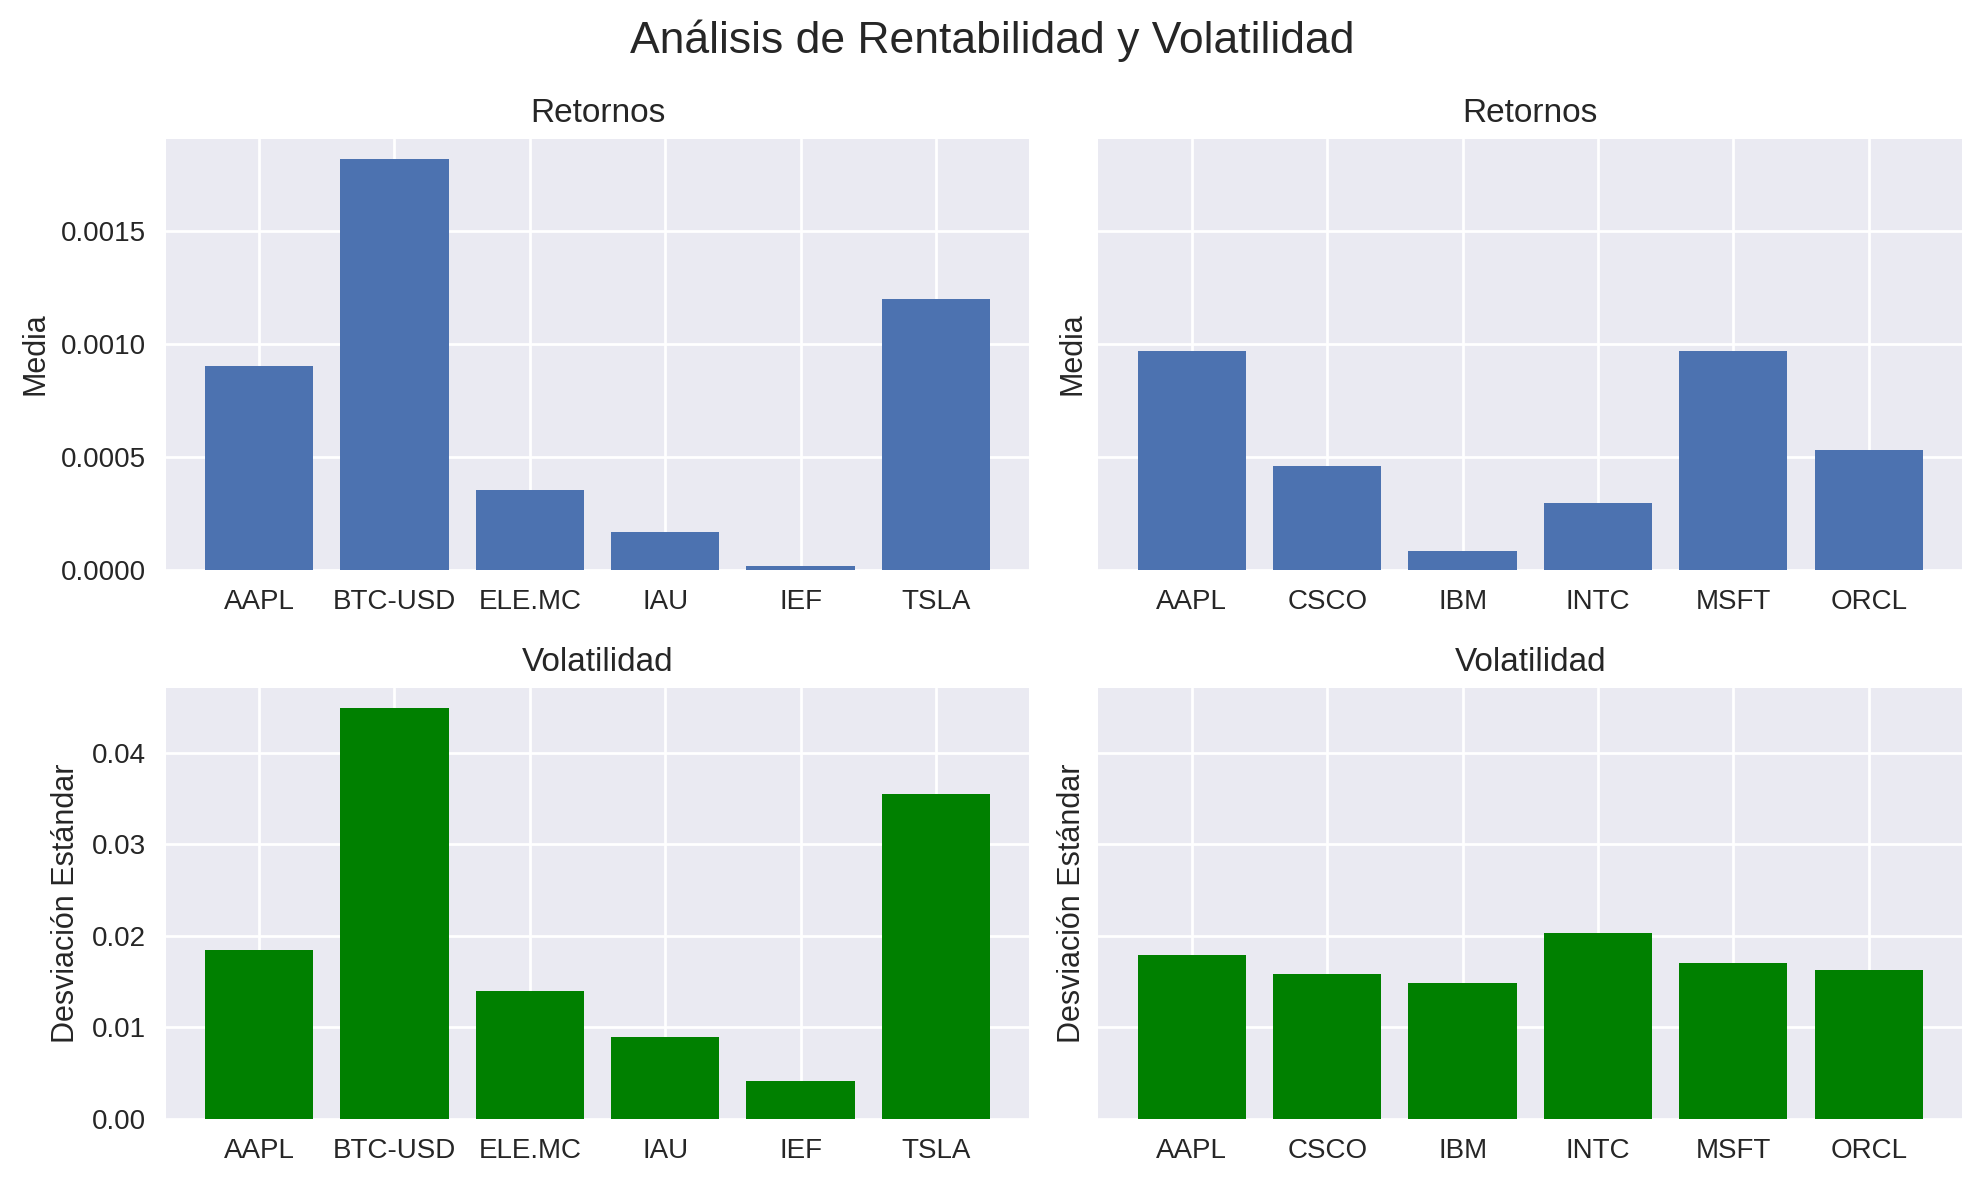

In [30]:
# Puedes calcular los valores medios y la desviación estándar de cada columna así:
means = ret_close_df.mean()
stds = ret_close_df.std()
means_corr = ret_close_df_corr.mean()
stds_corr = ret_close_df_corr.std()

# Crear una figura con dos subplots, uno encima del otro
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey='row')

# Crear el gráfico de barras de los valores medios en la parte superior
axes[0, 0].bar(means.index, means.values)
axes[0, 0].set_ylabel('Media')
axes[0, 0].set_title('Retornos')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1, 0].bar(stds.index, stds.values,color='green')
axes[1, 0].set_ylabel('Desviación Estándar')
axes[1, 0].set_title('Volatilidad')

#Crear una figura con dos subplots, uno encima del otro
axes[0, 1].bar(means_corr.index, means_corr.values)
axes[0, 1].set_ylabel('Media')
axes[0, 1].set_title('Retornos')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1, 1].bar(stds_corr.index, stds_corr.values,color='green')
axes[1, 1].set_ylabel('Desviación Estándar')
axes[1, 1].set_title('Volatilidad')

# Añadir un título general a la figura
plt.suptitle('Análisis de Rentabilidad y Volatilidad', fontsize=16)  # Título general

# Ajustar el espaciado entre los subplots para que no se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()

También podemos verlo usando las gráficas de distribución de los retornos diarios de cada activo.

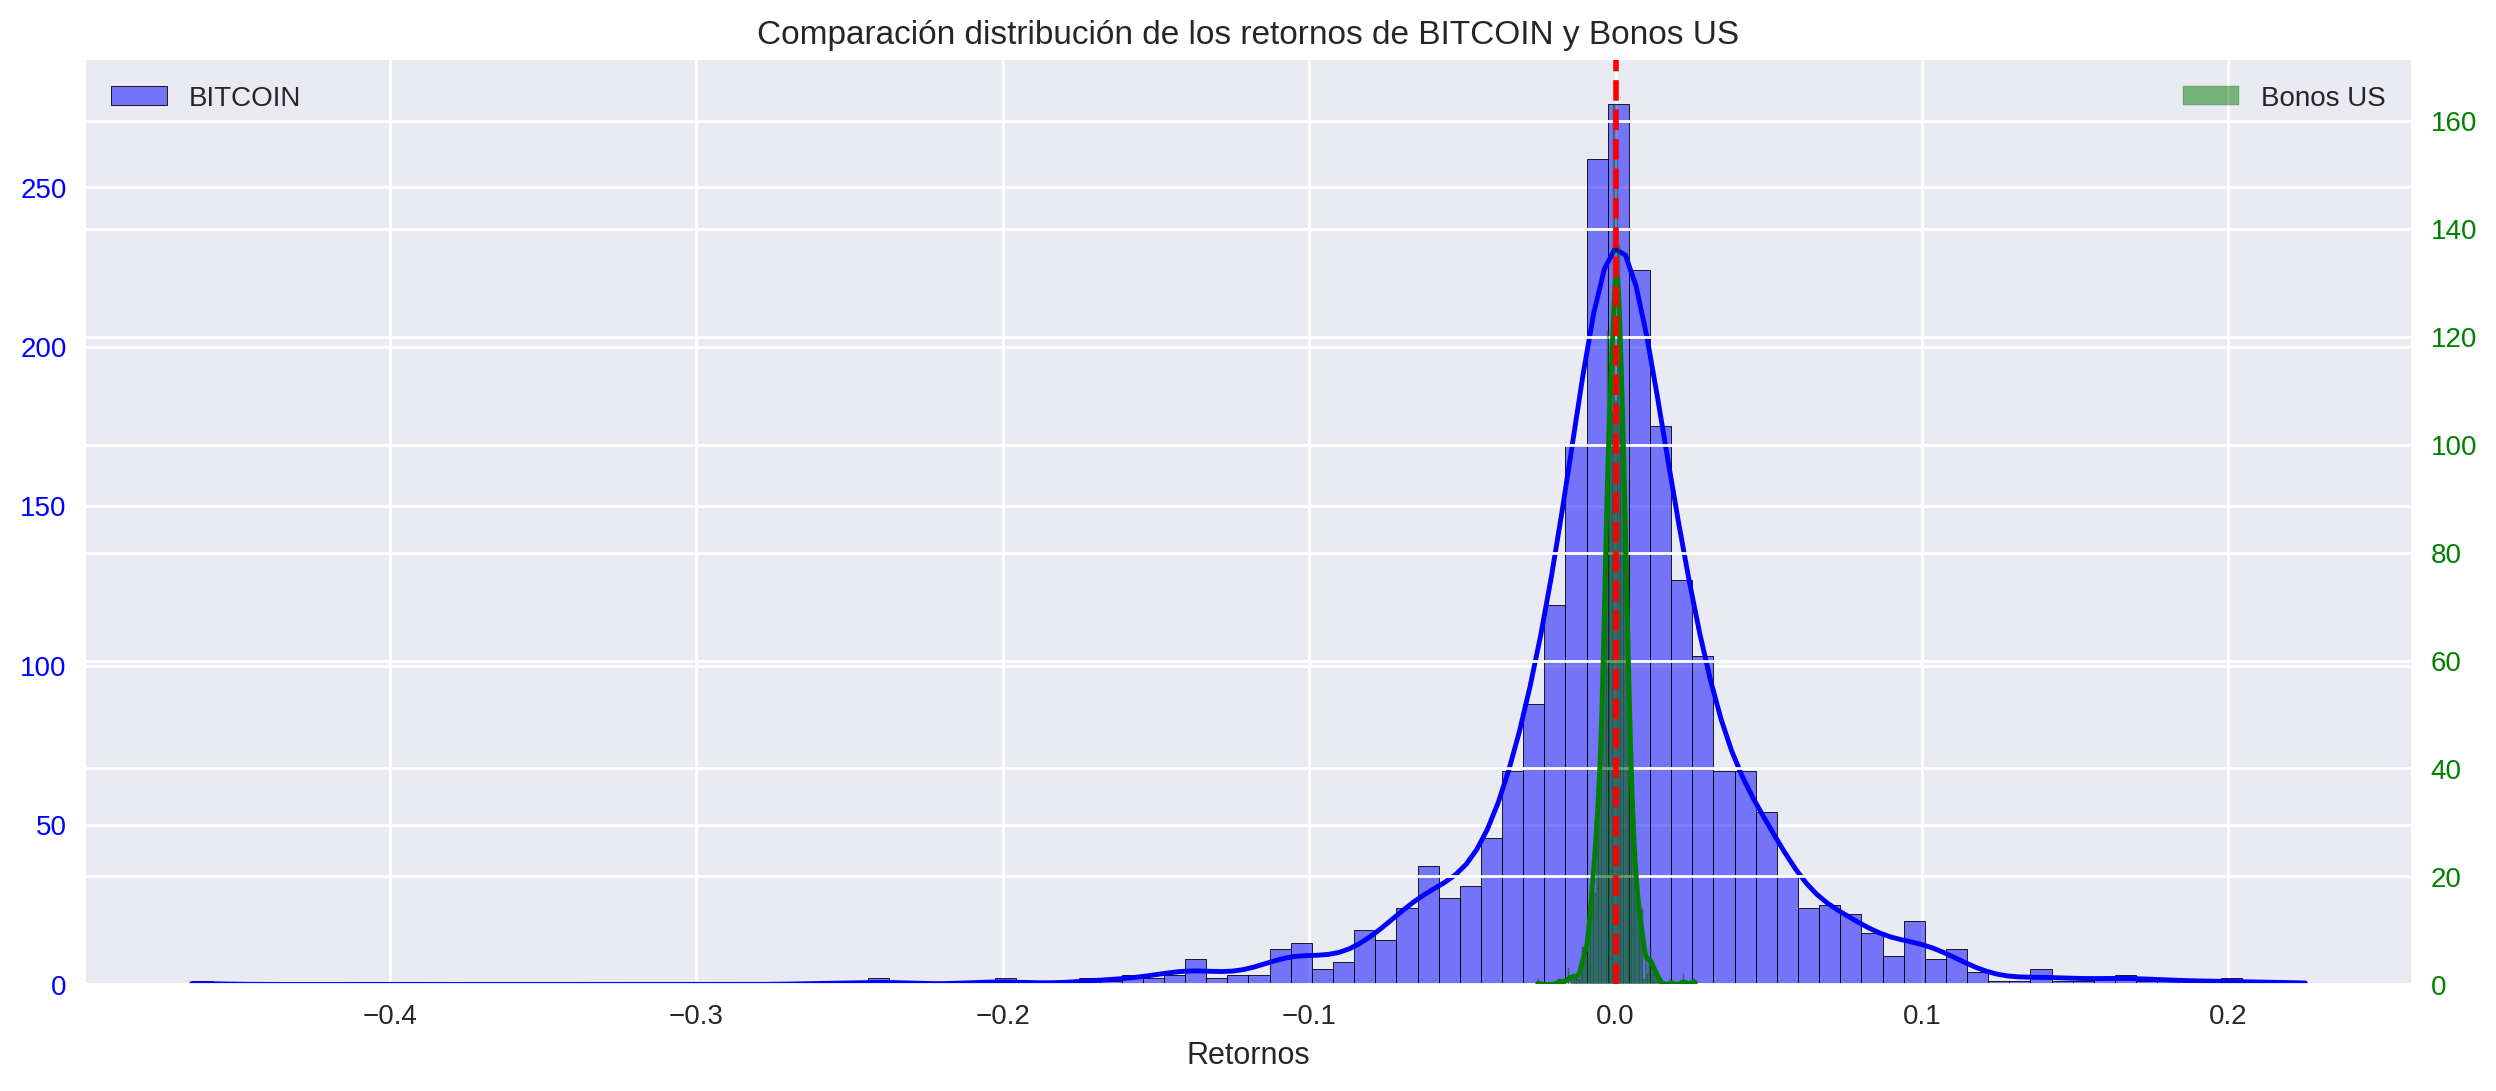

In [125]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Crear el primer gráfico con sns.histplot
sns.histplot(data=ret_close_df, x='BTC-USD', ax=ax1, bins=100, color='blue', kde=True, alpha=0.5, label='BITCOIN')
ax1.set_xlabel('Retornos')
ax1.set_ylabel('', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Duplicar el eje Y para el segundo gráfico
ax2 = ax1.twinx()

# Crear el segundo gráfico con sns.histplot
sns.histplot(data=ret_close_df, x='IEF', ax=ax2, bins=100, color='green', kde=True, alpha=0.5, label='Bonos US')
ax2.set_ylabel('', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# Añadir una línea vertical en el eje X en 0
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
# Configurar título y mostrar el gráfico
plt.title('Comparación distribución de los retornos de BITCOIN y Bonos US')
plt.show()

La teoría de que los activos se pueden caracterizar por el binomio rentabilidad-riesgo solo se cumple si:

* La función de utilidad del inversor es cuadrática (media-varianza). Fuera del scope de este curso.

* Los **retornos siguen una distribución normal**. Esto es lo que vamos a comprobar.

Para comprobarlo vamos a usar los retornos del Bitcoin y los vamos a comparar con una distribución normal (con la misma media y desviación estándar que los retornos de Bitcoin)
     

Generamos unos datos sintéticos con distribución normal, media y desviación igual a la de los retornos del Bitcoin

In [ ]:
# Definir la media y la desviación estándar
media = ret_close_df['BTC-USD'].mean()
std = ret_close_df['BTC-USD'].std()

# Establecer la semilla (seed)
np.random.seed(3)  # Puedes usar cualquier número como semilla

# Generar una serie de números con distribución normal
data_norm = np.random.normal(media, std, 100000)  # 100000 números aleatorios

Como primera manera de analizar si los retornos siguen una distribución normal, usaremos los gráficos QQ-Plot.

Si los puntos se ajustan a la recta, los datos siguen una distribución normal.

Para más información sobre QQ-Plot pinchar [aquí](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)

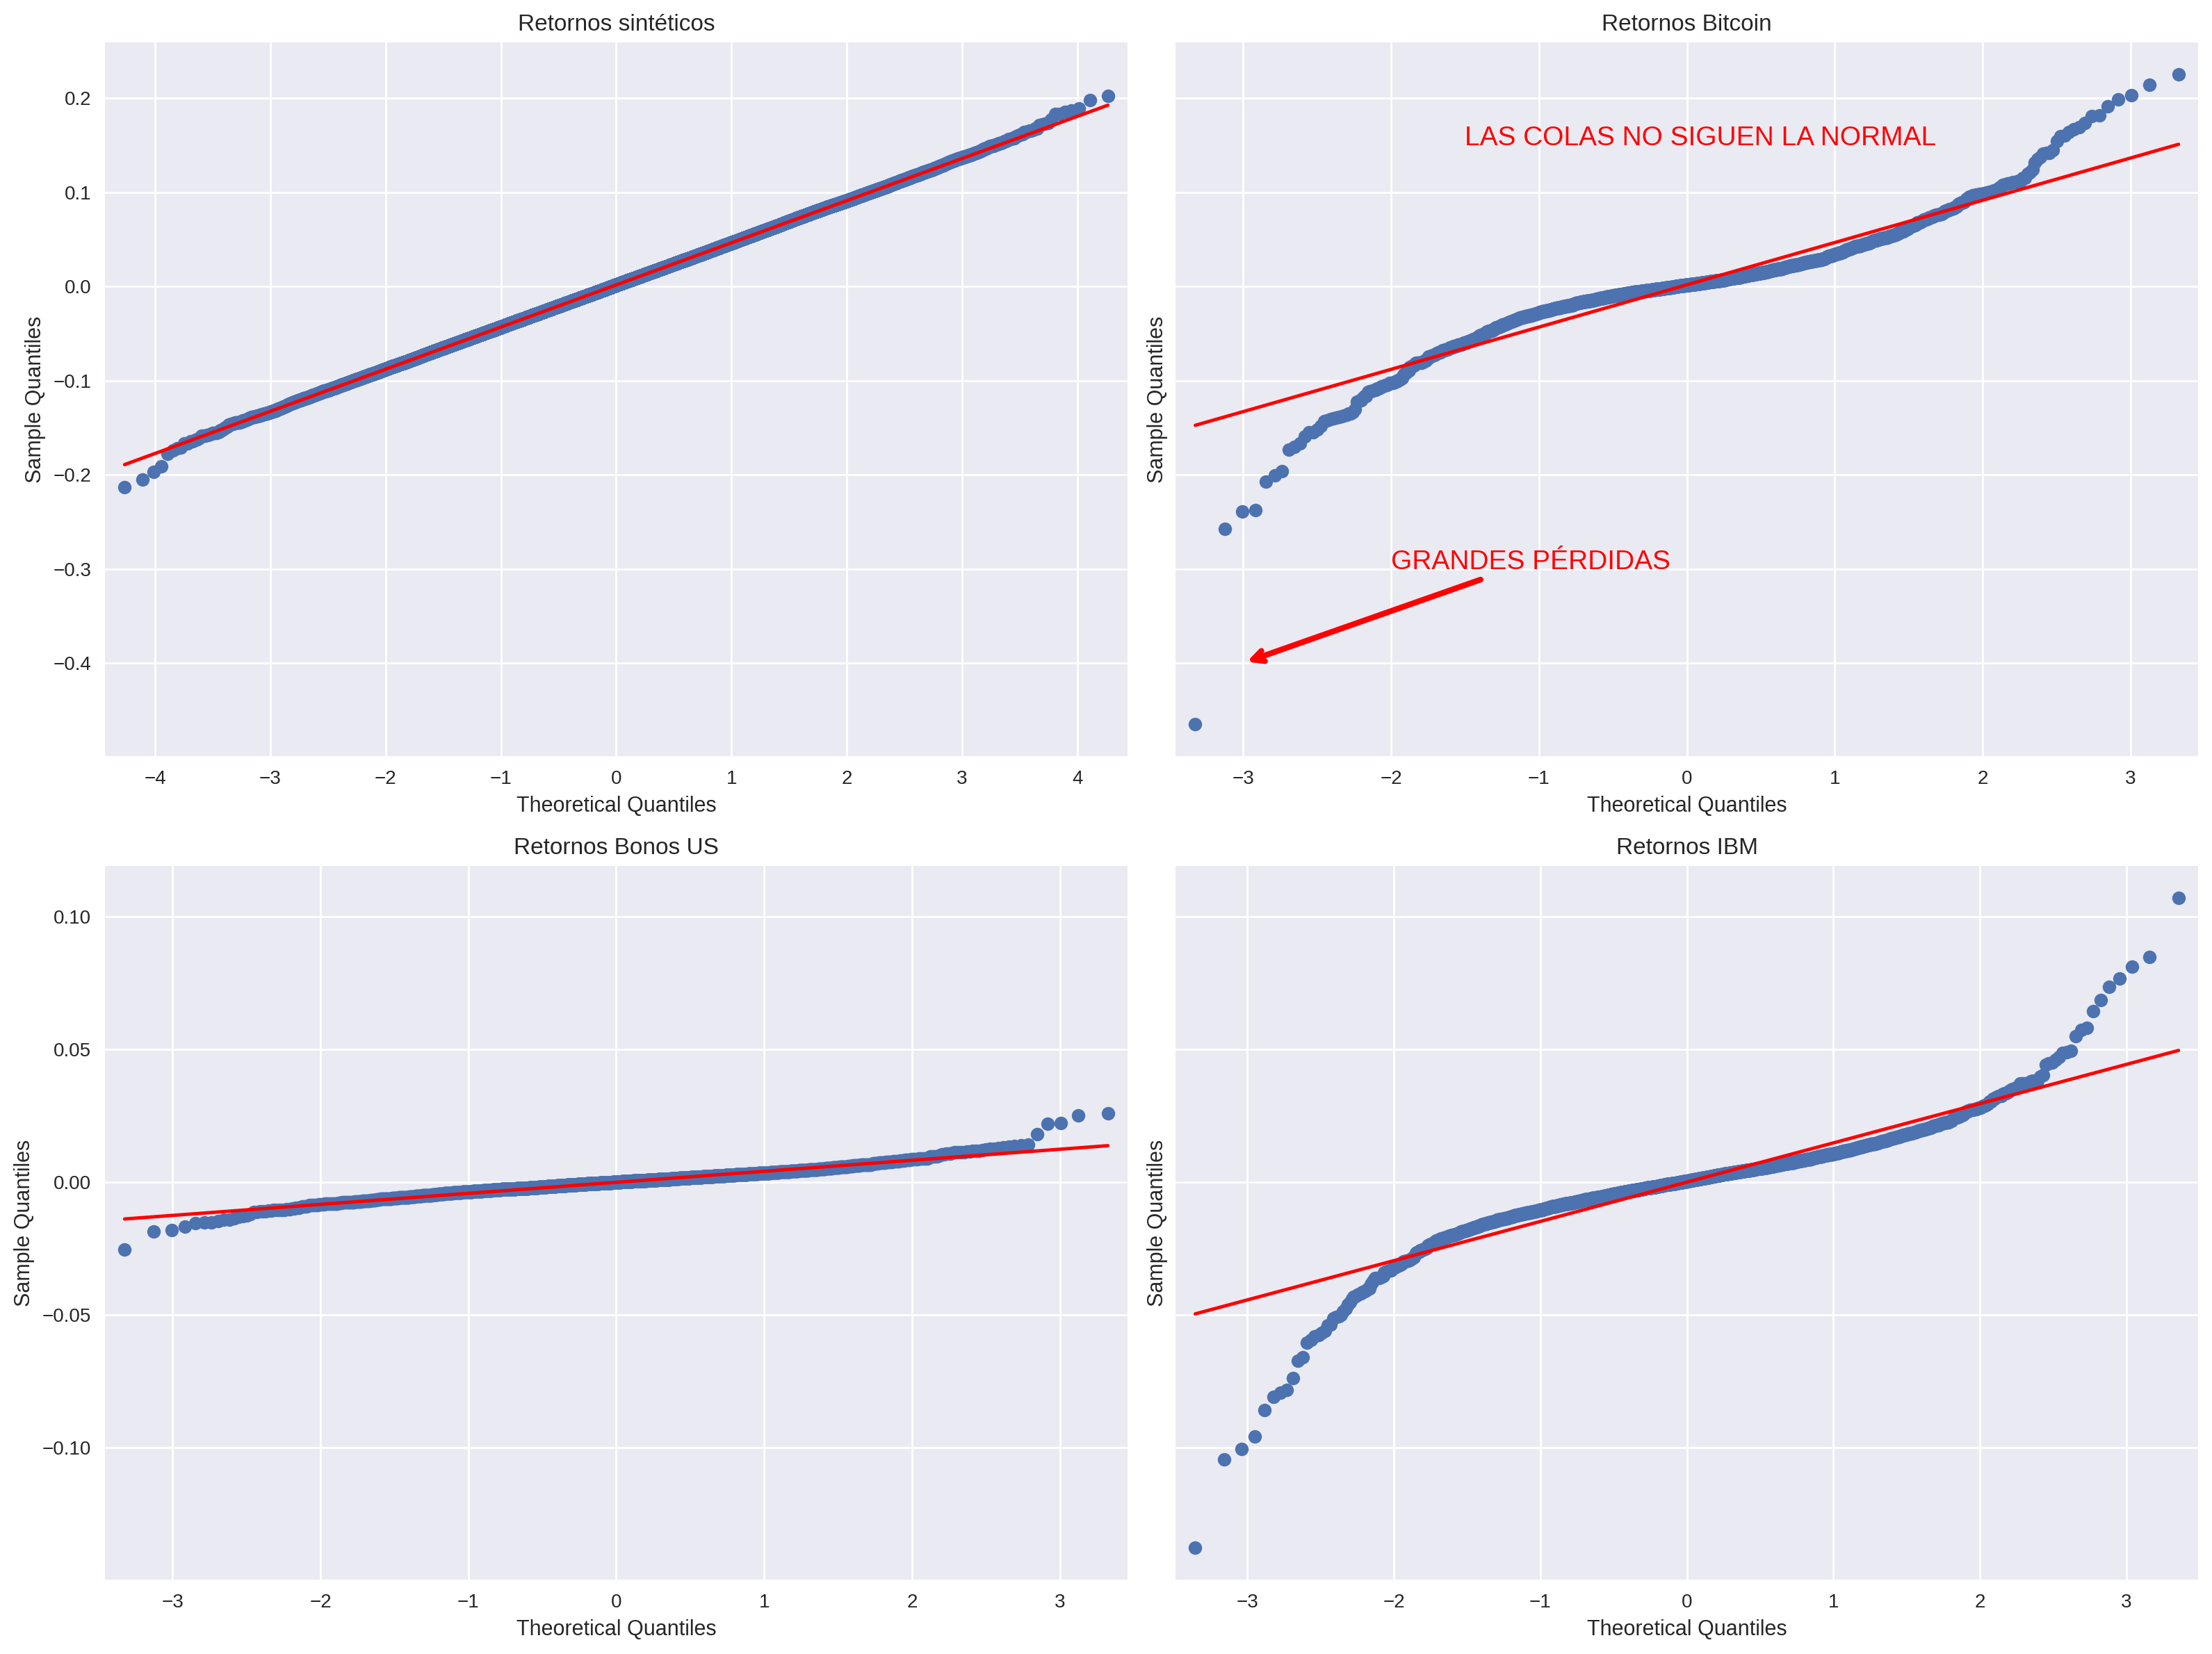

In [173]:

# Crear una figura con dos subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharey='row')

# Graficar el primer histograma en el primer subplot
sm.qqplot(data_norm, line='s', ax=axs[0,0])
axs[0,0].set_title('Retornos sintéticos')

# Graficar el segundo histograma en el segundo subplot
sm.qqplot(ret_close_df['BTC-USD'], line='s', ax=axs[0,1])
axs[0,1].set_title('Retornos Bitcoin')

# Añadir texto en ax2
text_x = -3
text_y = -0.35

#axs[0,1].text(text_x, text_y, "GRANDES PÉRDIDAS", fontsize=14, color='RED')

text_x = -1.5
text_y = 0.15

axs[0,1].text(text_x, text_y, "LAS COLAS NO SIGUEN LA NORMAL", fontsize=14, color='RED')

# axs[0,1].annotate('LAS COLAS NO SIGUEN LA NORMAL', xy=(2.2, 0.17), xytext=(-2, -0.3),
#             arrowprops=dict(arrowstyle='->', linewidth=3, color='red'),
#             fontsize=14, color='RED')

# Dibuja una flecha utilizando annotate
axs[0,1].annotate('GRANDES PÉRDIDAS', xy=(-3, -0.4), xytext=(-2, -0.3),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='red'),
            fontsize=14, color='RED')


# Graficar el segundo histograma en el segundo subplot
sm.qqplot(ret_close_df['IEF'], line='s', ax=axs[1,0])
axs[1,0].set_title('Retornos Bonos US')

# Graficar el segundo histograma en el segundo subplot
sm.qqplot(ret_close_df_corr['IBM'], line='s', ax=axs[1,1])
axs[1,1].set_title('Retornos IBM')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

In [149]:
# Definir la media y la desviación estándar
media = ret_close_df['BTC-USD'].mean()
std = ret_close_df['BTC-USD'].std()

# Establecer la semilla (seed)
np.random.seed(3)  # Puedes usar cualquier número como semilla

# Generar una serie de números con distribución normal
data_norm = np.random.normal(media, std, 100000)  # 100000 números aleatorios

# Calcular la asimetría (skewness)
skewness = np.mean((data_norm - media) ** 3) / np.power(std, 3)

# Calcular la curtosis (kurtosis)
kurtosis = np.mean((data_norm - media) ** 4) / np.power(std, 4) - 3

print(f'Asimetría (Skewness): {skewness:.2f}')
print(f'Curtosis (Kurtosis): {kurtosis:.2f}')


Asimetría (Skewness): 0.00
Curtosis (Kurtosis): -0.02


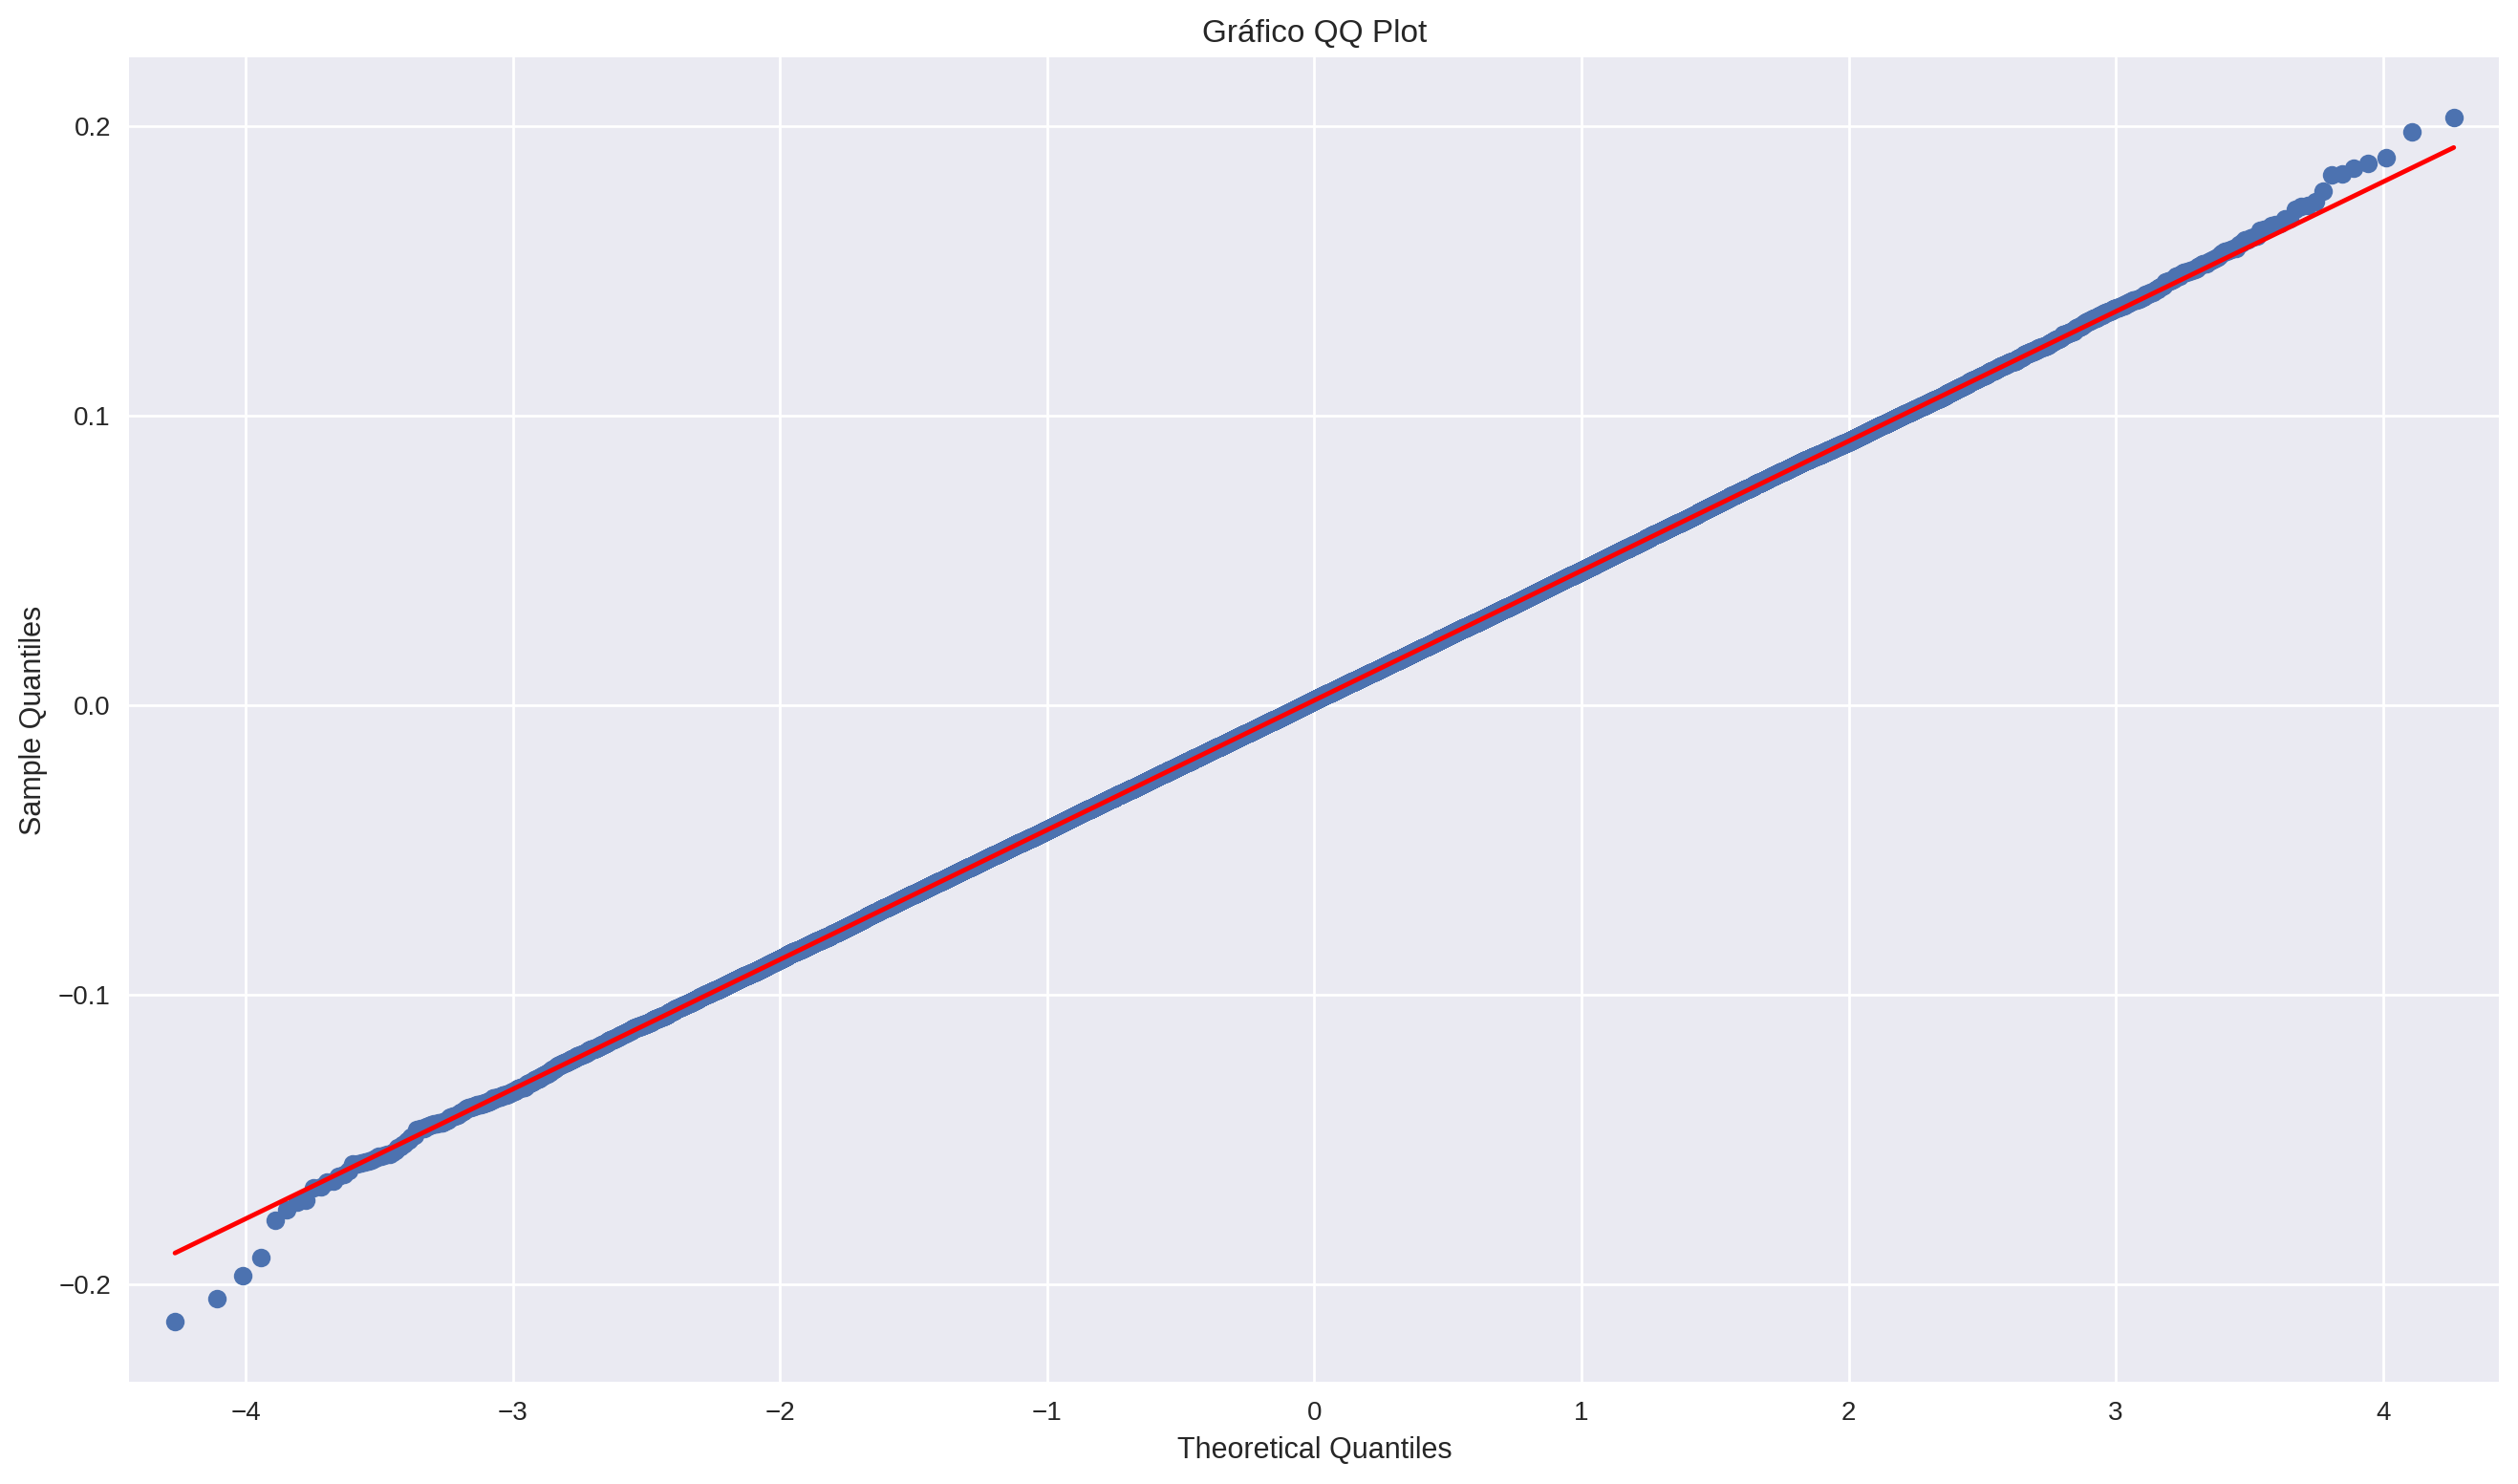

In [146]:
sm.qqplot(data_norm, line='s')
plt.title('Gráfico QQ Plot')
plt.show()

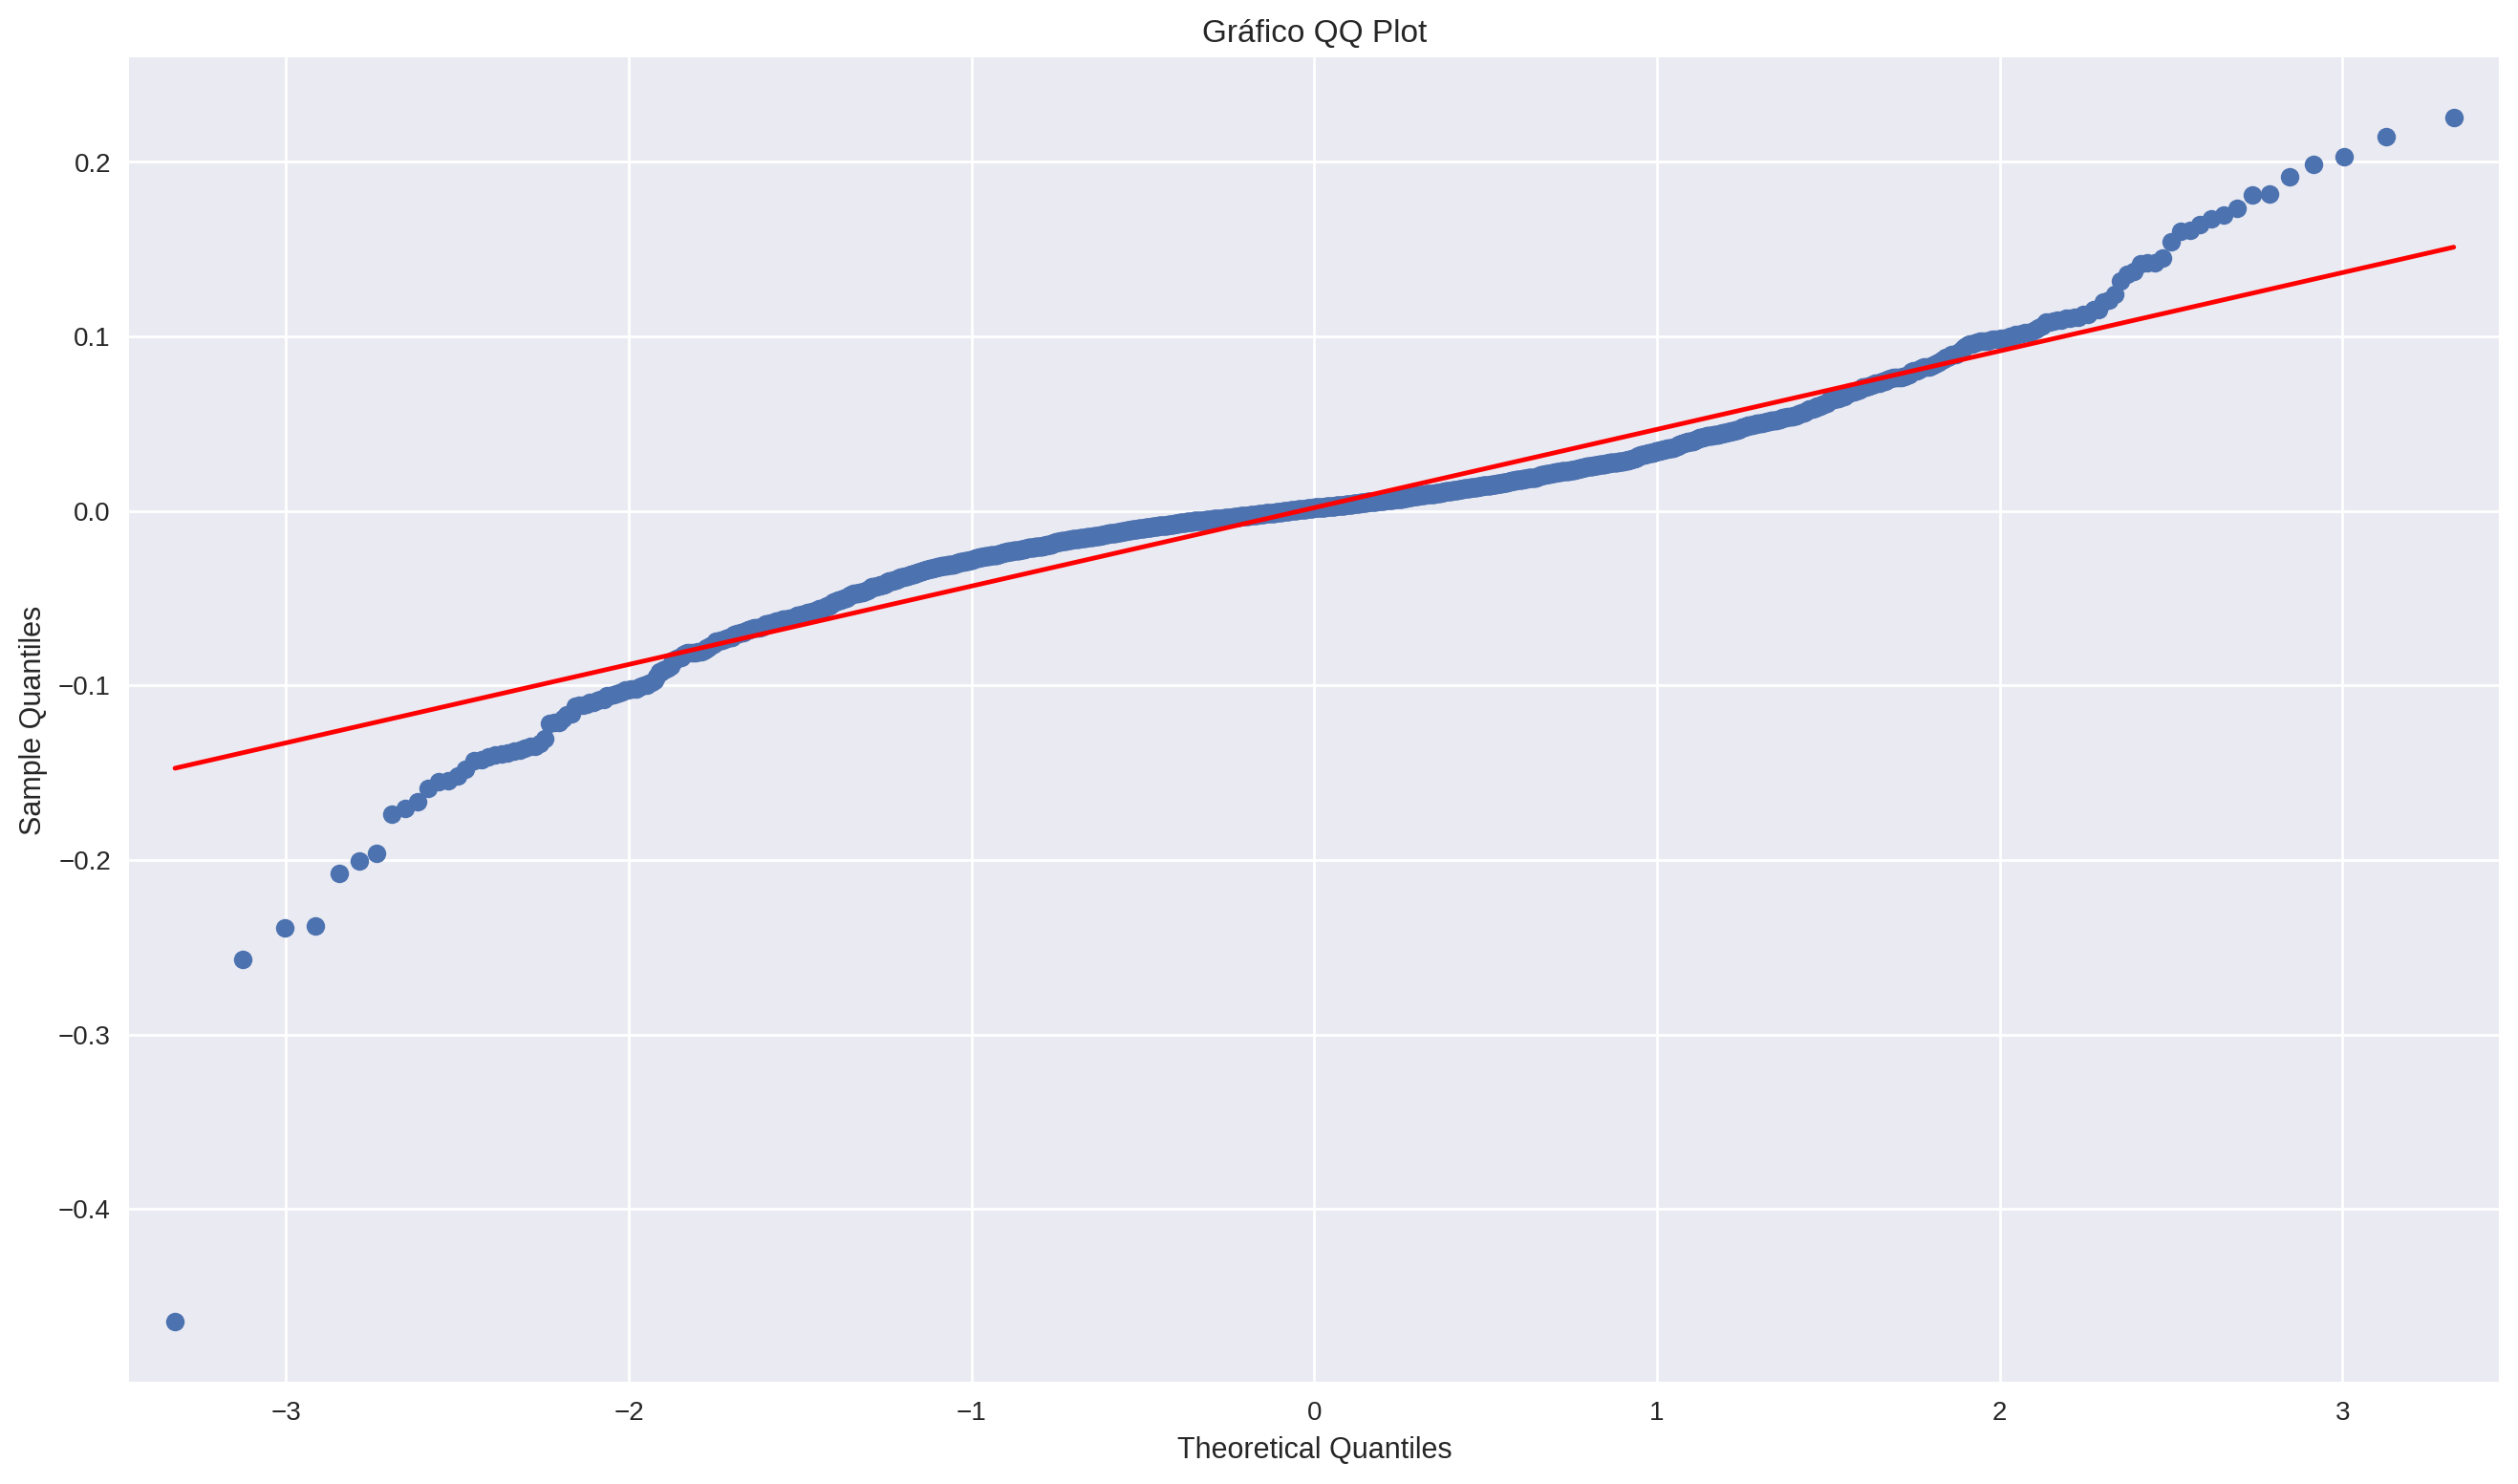

In [142]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

sm.qqplot(ret_close_df['BTC-USD'], line='s')
plt.title('Gráfico QQ Plot')
plt.show()

In [127]:
# Supongamos que 'ret_df' tiene una columna llamada 'Retornos'

asimetría = ret_close_df['BTC-USD'].skew()
curtosis = ret_close_df['BTC-USD'].kurtosis()

print(f'Media: {media:.2f}')
print(f'Desviación Estándar: {std:.2f}')
print(f'Asimetría (Skewness): {asimetría:.2f}')
print(f'Curtosis (Kurtosis): {curtosis:.2f}')

Media: 0.00
Desviación Estándar: 0.04
Asimetría (Skewness): -0.66
Curtosis (Kurtosis): 9.02


In [73]:
ret_close_df_corr.skew()

AAPL   -0.233843
CSCO   -0.694927
IBM    -0.778999
INTC   -0.587025
MSFT   -0.123259
ORCL    0.312141
dtype: float64

In [72]:
print(ret_close_df['AAPL'].skew(), ret_close_df['AAPL'].kurtosis())
print(ret_close_df['IEF'].skew(), ret_close_df['IEF'].kurtosis())
print(ret_close_df['BTC-USD'].skew(), ret_close_df['BTC-USD'].kurtosis())
print(pd.DataFrame(pdf_normal).skew(), pd.DataFrame(pdf_normal).kurtosis())


-0.20534033016625575 5.293072422693196
0.1317096834701444 3.495305731855623
-0.65565958490211 9.018971773307502
0    0.942233
dtype: float64 0   -0.661131
dtype: float64


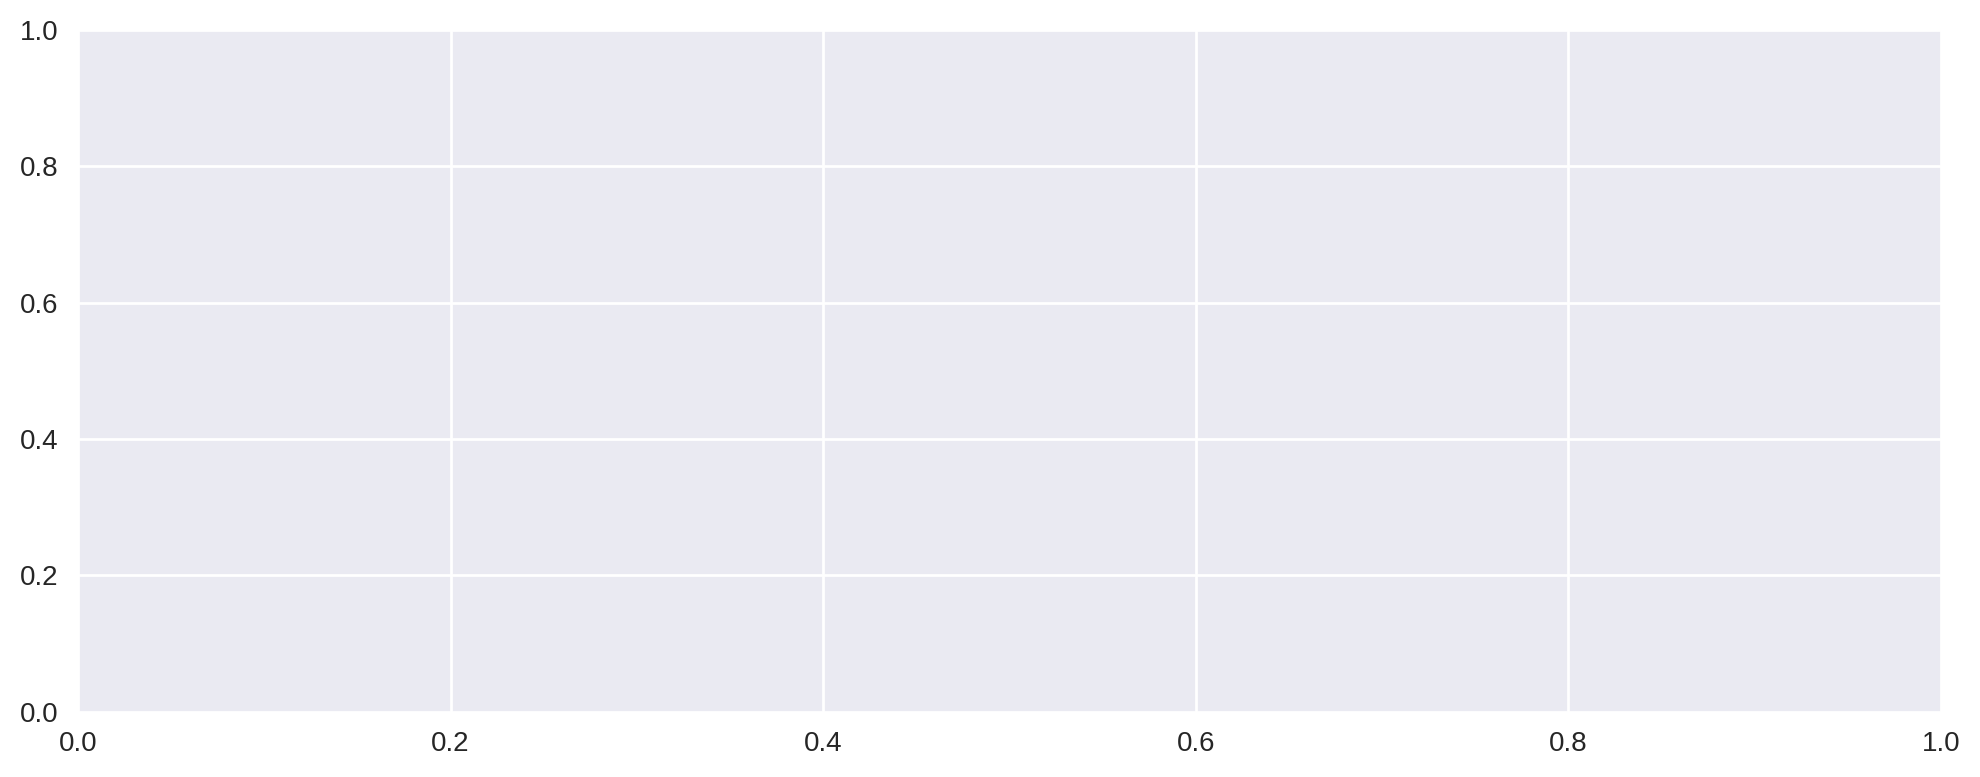

In [119]:
fig, ax = plt.subplots(figsize=(10, 4)) 

sns.histplot(data=ret_close_df_corr, x='IBM', ax=ax1, bins=500, color='blue', kde=True, alpha=0.5, label='IBM')
sns.histplot(data=ret_close_df, x='IEF', ax=ax2, bins=500, color='green', kde=True, alpha=0.5, label='Bonos US')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

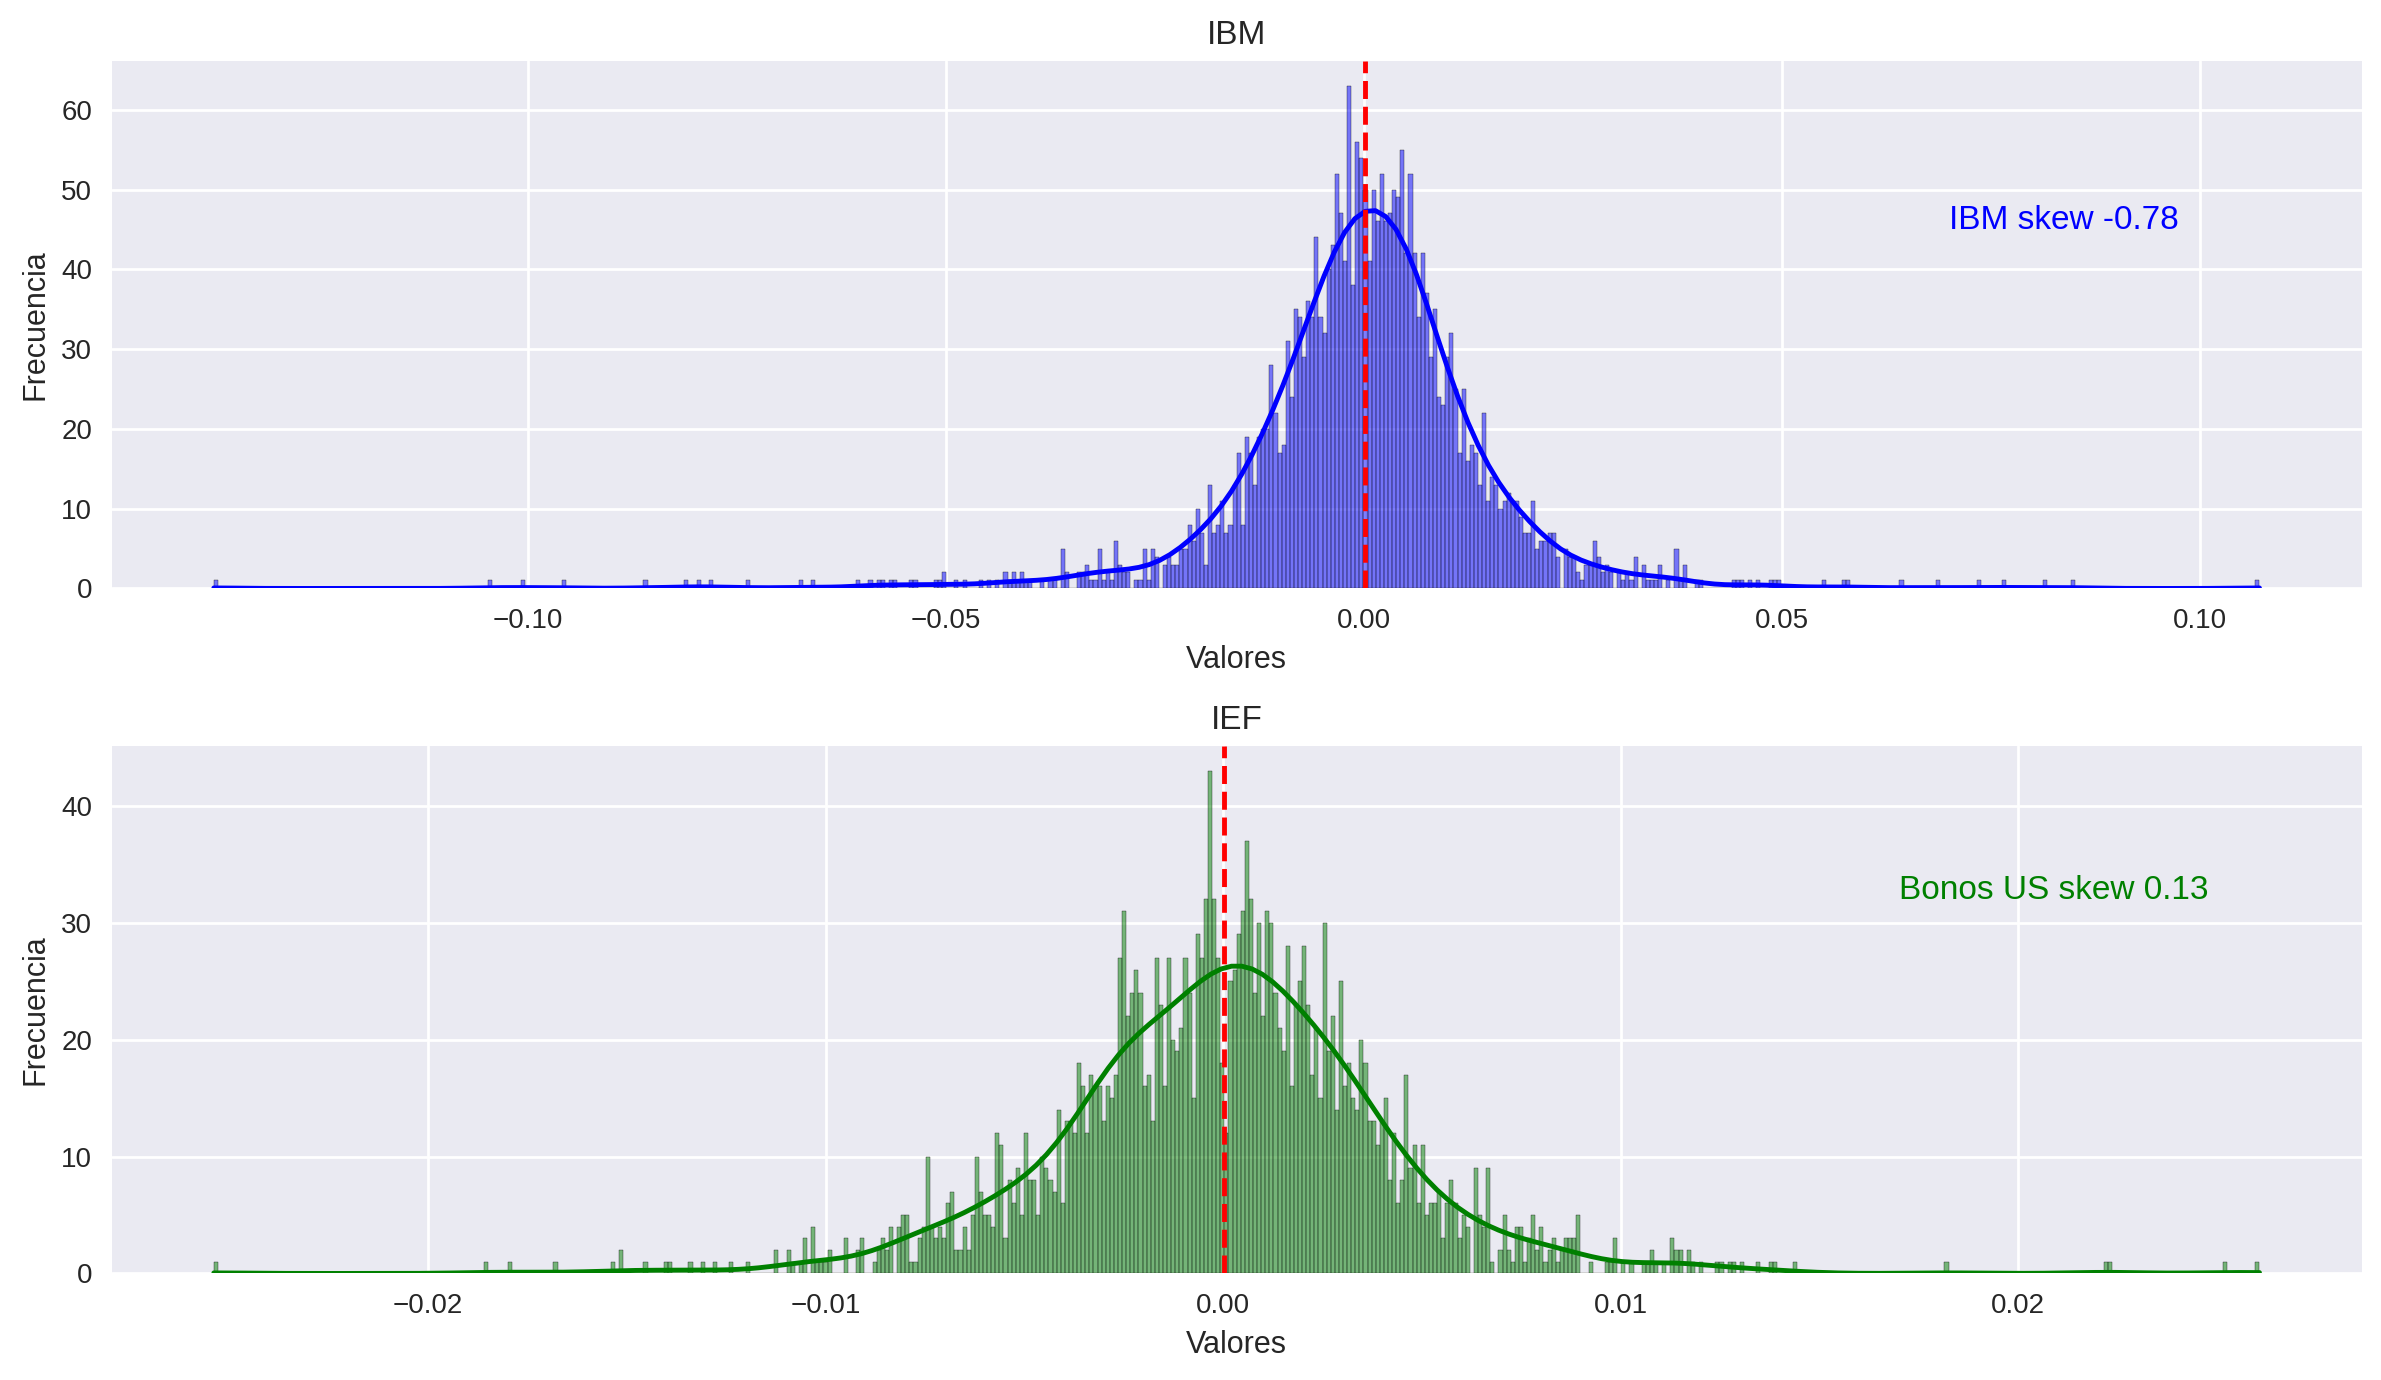

In [116]:

# Crear una figura con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7))

# Graficar el primer histograma en el primer subplot
sns.histplot(data=ret_close_df_corr, x='IBM', ax=ax1, bins=500, color='blue', kde=True, alpha=0.5, label='IBM')
ax1.set_xlabel('Valores')
ax1.set_ylabel('Frecuencia')
ax1.set_title('IBM')
ax1.axvline(x=ret_close_df_corr['IBM'].mean(), color='red', linestyle='--', label='Media')

# Añadir texto en ax1
text_x = 0.07
text_y = 45
ax1.text(text_x, text_y, f"IBM skew {ret_close_df_corr.loc[:, 'IBM'].skew():.2f}", fontsize=12, color='blue')

# Graficar el segundo histograma en el segundo subplot
sns.histplot(data=ret_close_df, x='IEF', ax=ax2, bins=500, color='green', kde=True, alpha=0.5, label='Bonos US')
ax2.set_xlabel('Valores')
ax2.set_ylabel('Frecuencia')
ax2.set_title('IEF')
ax2.axvline(x=ret_close_df['IEF'].mean(), color='red', linestyle='--', label='Media')

# Añadir texto en ax2
text_x = 0.017
text_y = 32

ax2.text(text_x, text_y, f"Bonos US skew {ret_close_df.loc[:, 'IEF'].skew():.2f}", fontsize=12, color='green')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

<Axes: xlabel='IBM', ylabel='Count'>

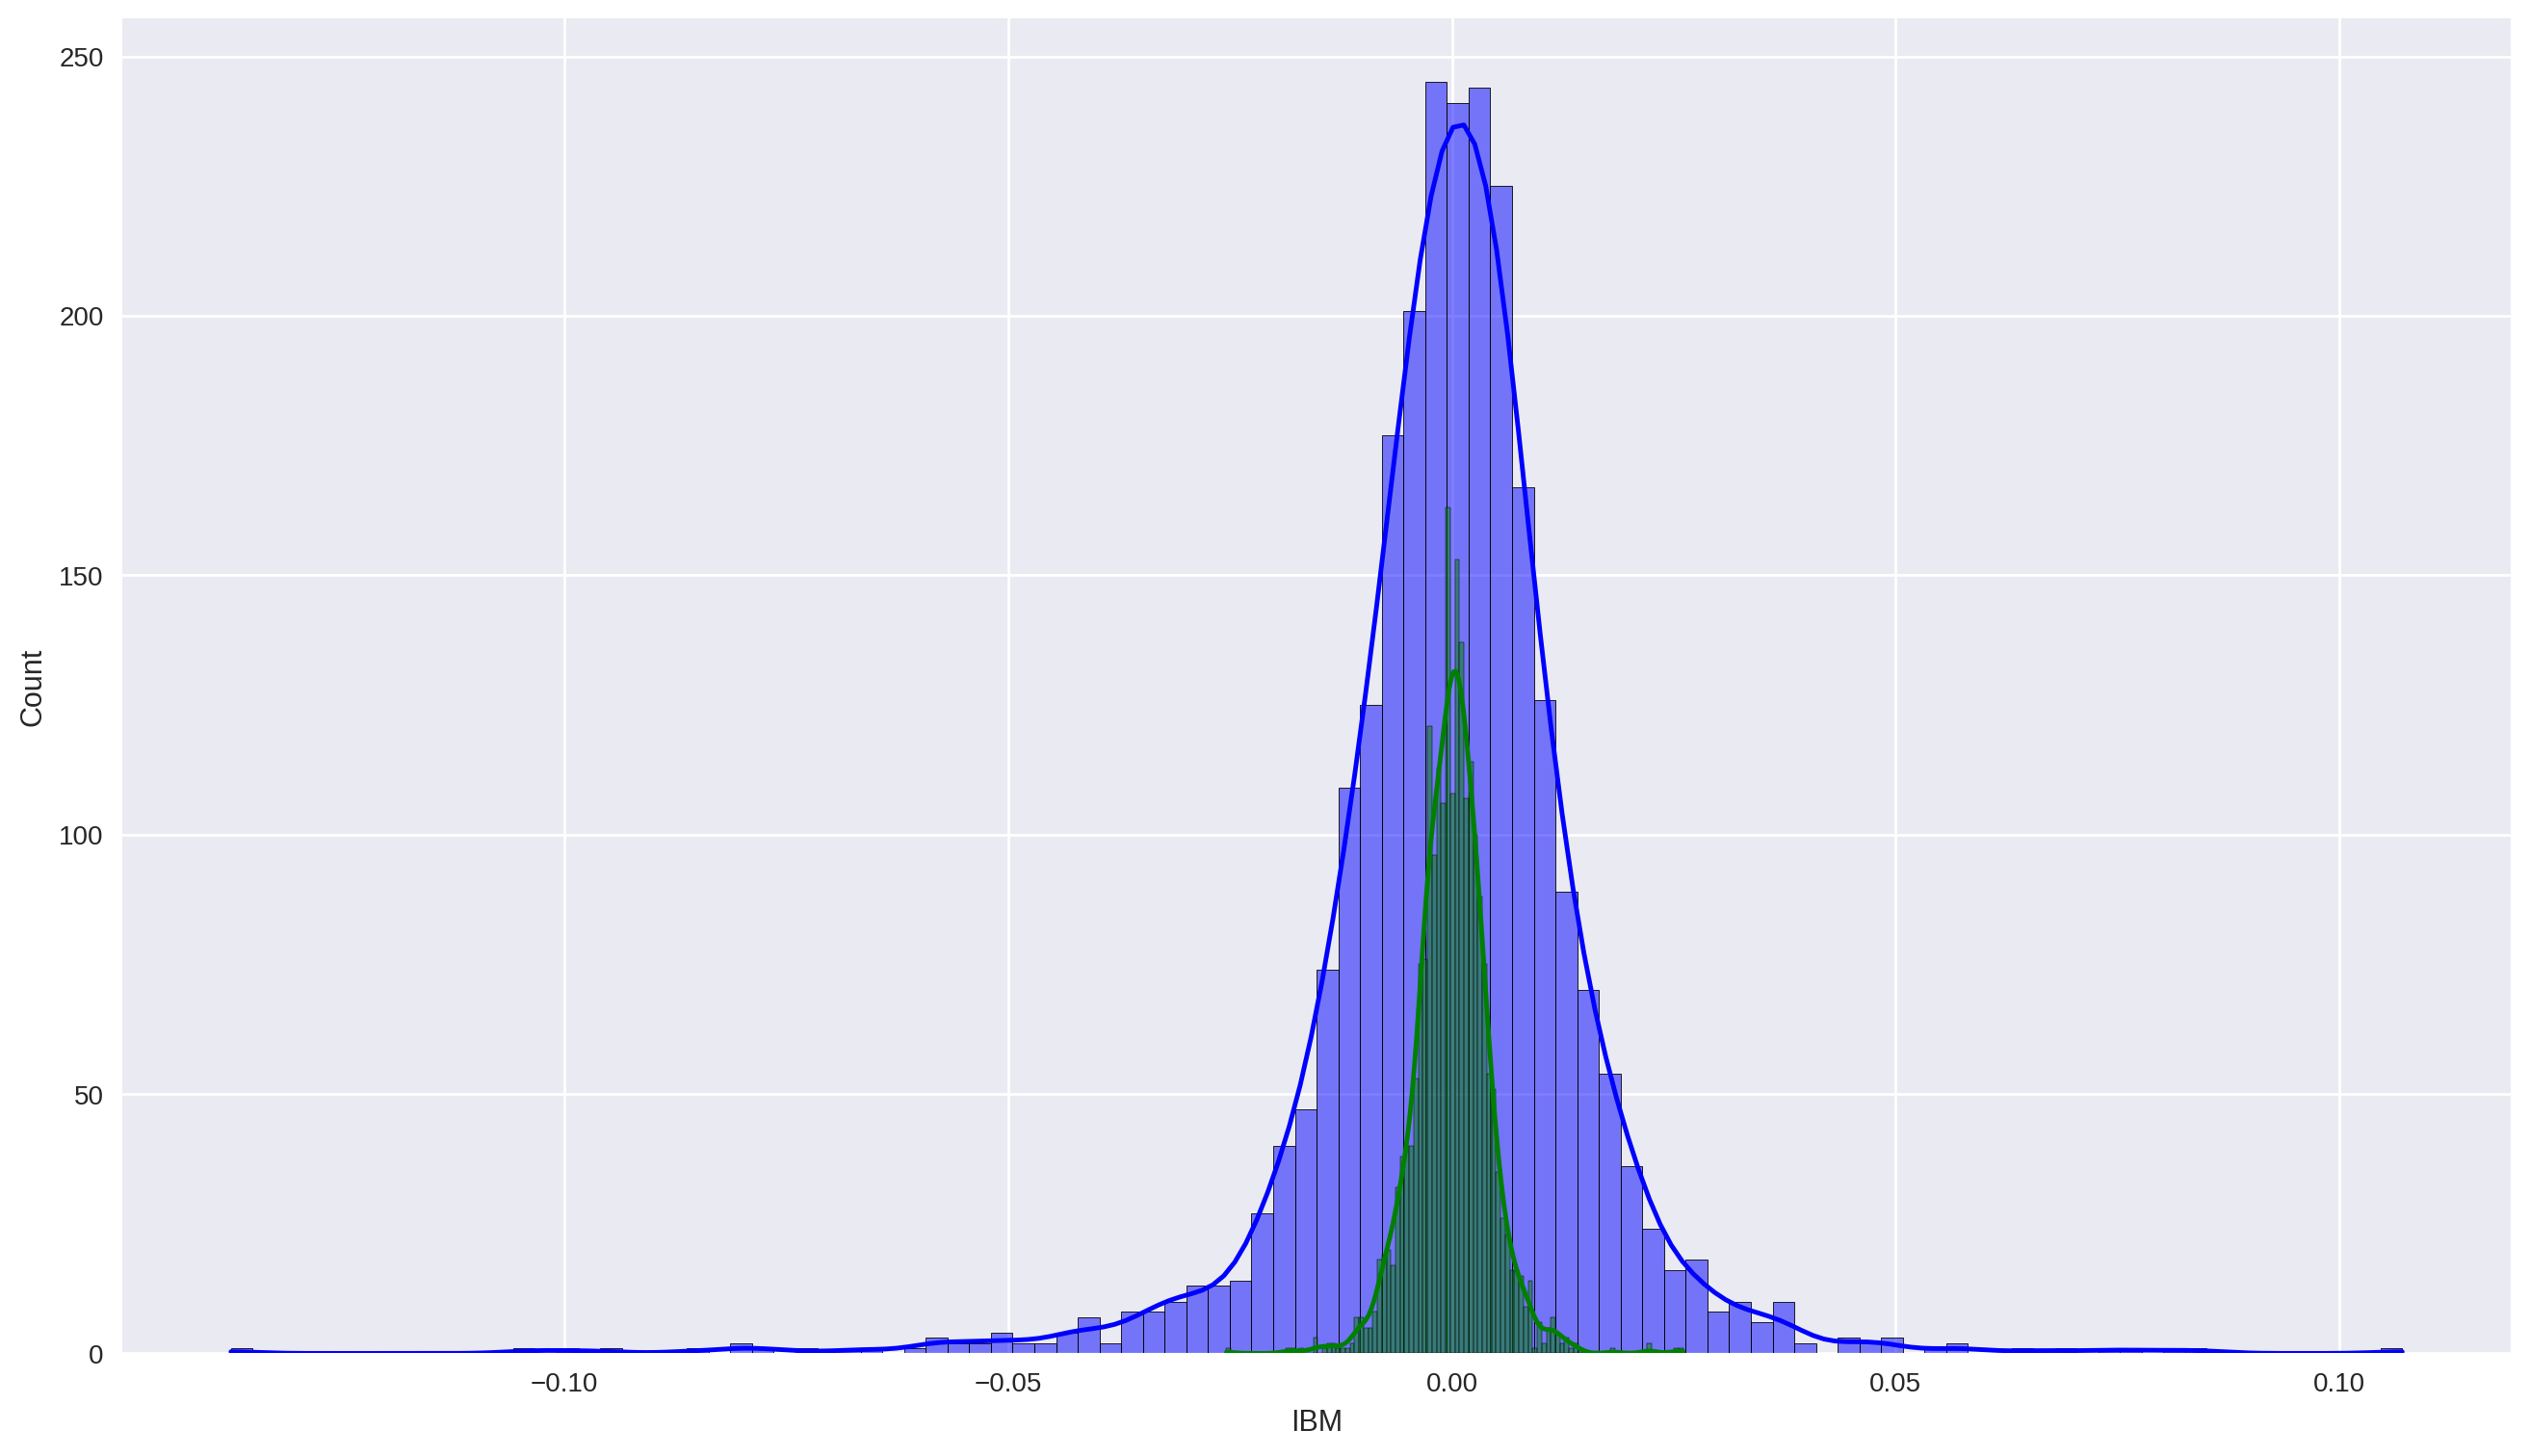

In [78]:
sns.histplot(data=ret_close_df_corr, x='IBM', bins=100, kde=True, color='blue', alpha=0.5)
sns.histplot(data=ret_close_df, x='IEF', bins=100, kde=True, color='green', alpha=0.5)

<Axes: xlabel='IEF', ylabel='Count'>

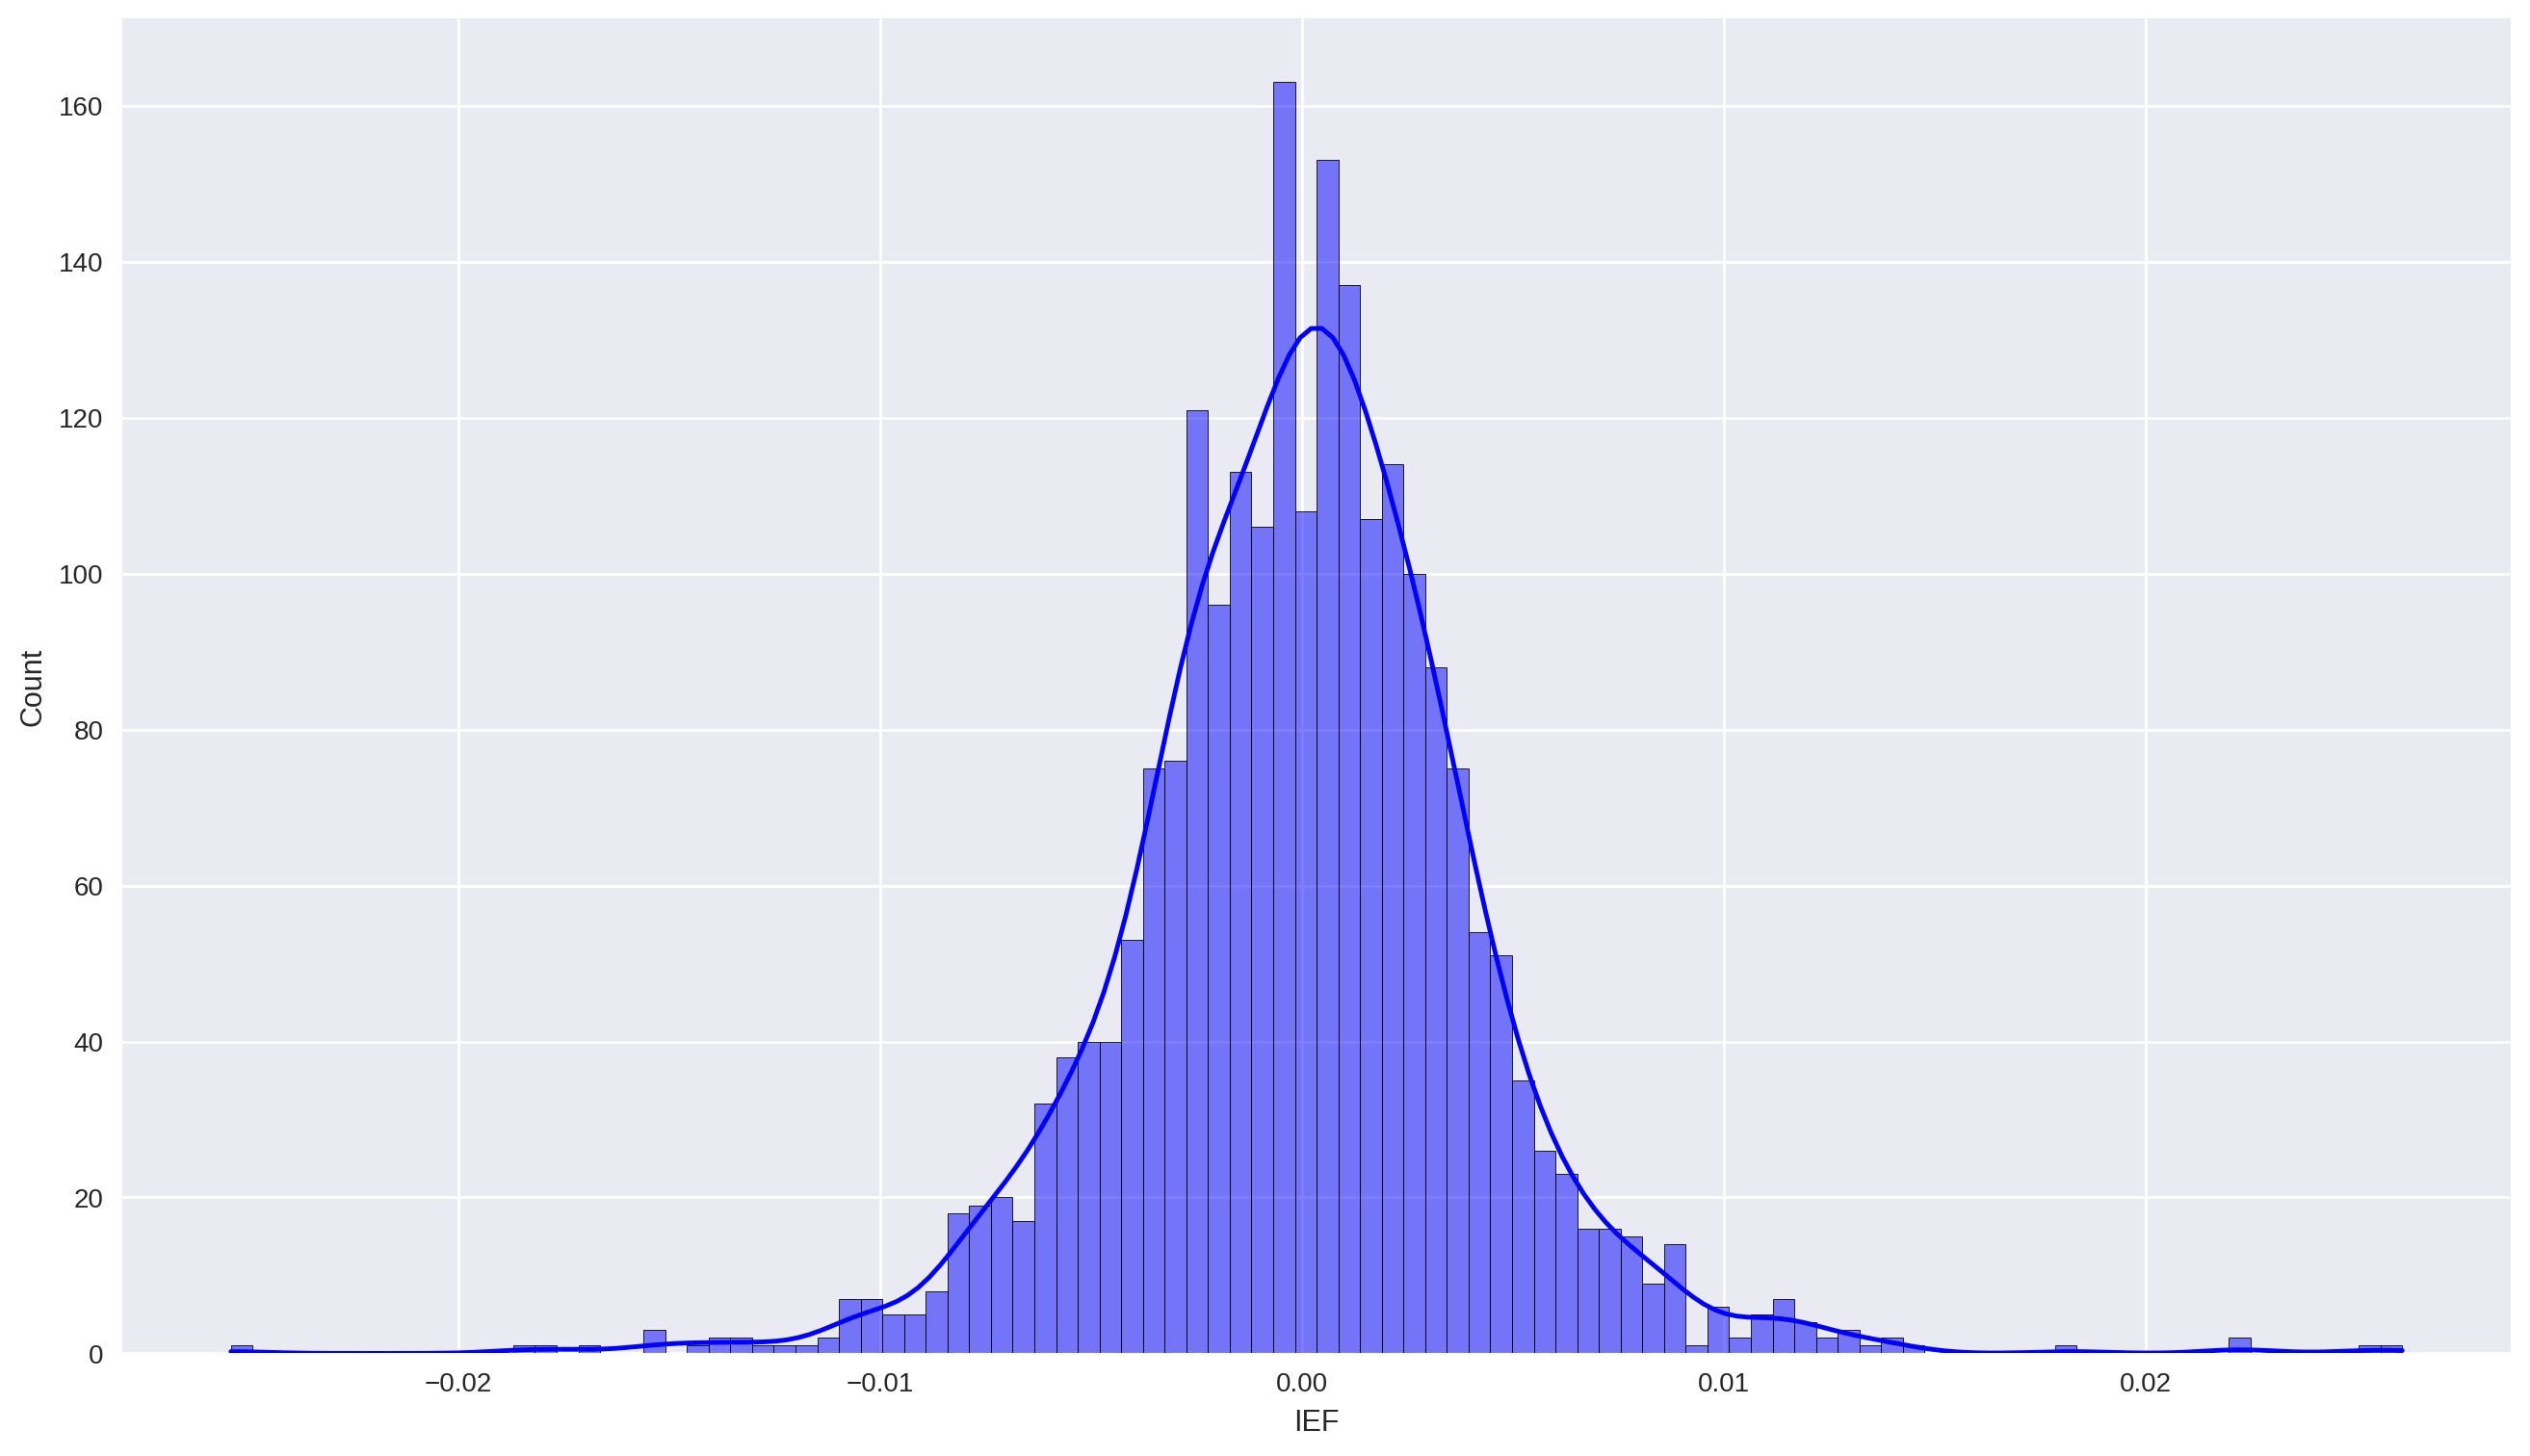

In [79]:
sns.histplot(data=ret_close_df, x='IEF', bins=100, kde=True, color='blue', alpha=0.5)

In [63]:
import scipy.stats as stats

# Calcular la media y la desviación estándar de los retornos
ret_mean = ret_close_df['BTC-USD'].mean()
ret_std = ret_close_df['BTC-USD'].std()

fig = px.histogram(ret_close_df, x='BTC-USD', nbins=1000, title='Histograma de Valores')

# Generar la distribución normal teórica basada en la media y la desviación estándar
x = np.linspace(-0.2, 0.2, 5000)
pdf_normal = stats.norm.pdf(x, loc=ret_mean, scale=ret_std)

# Añadir la línea de la distribución normal
fig.add_trace(px.line(x=x,
                      y=pdf_normal,
                      color_discrete_sequence=["red"]).data[0])



# Mostrar el gráfico
fig.show()

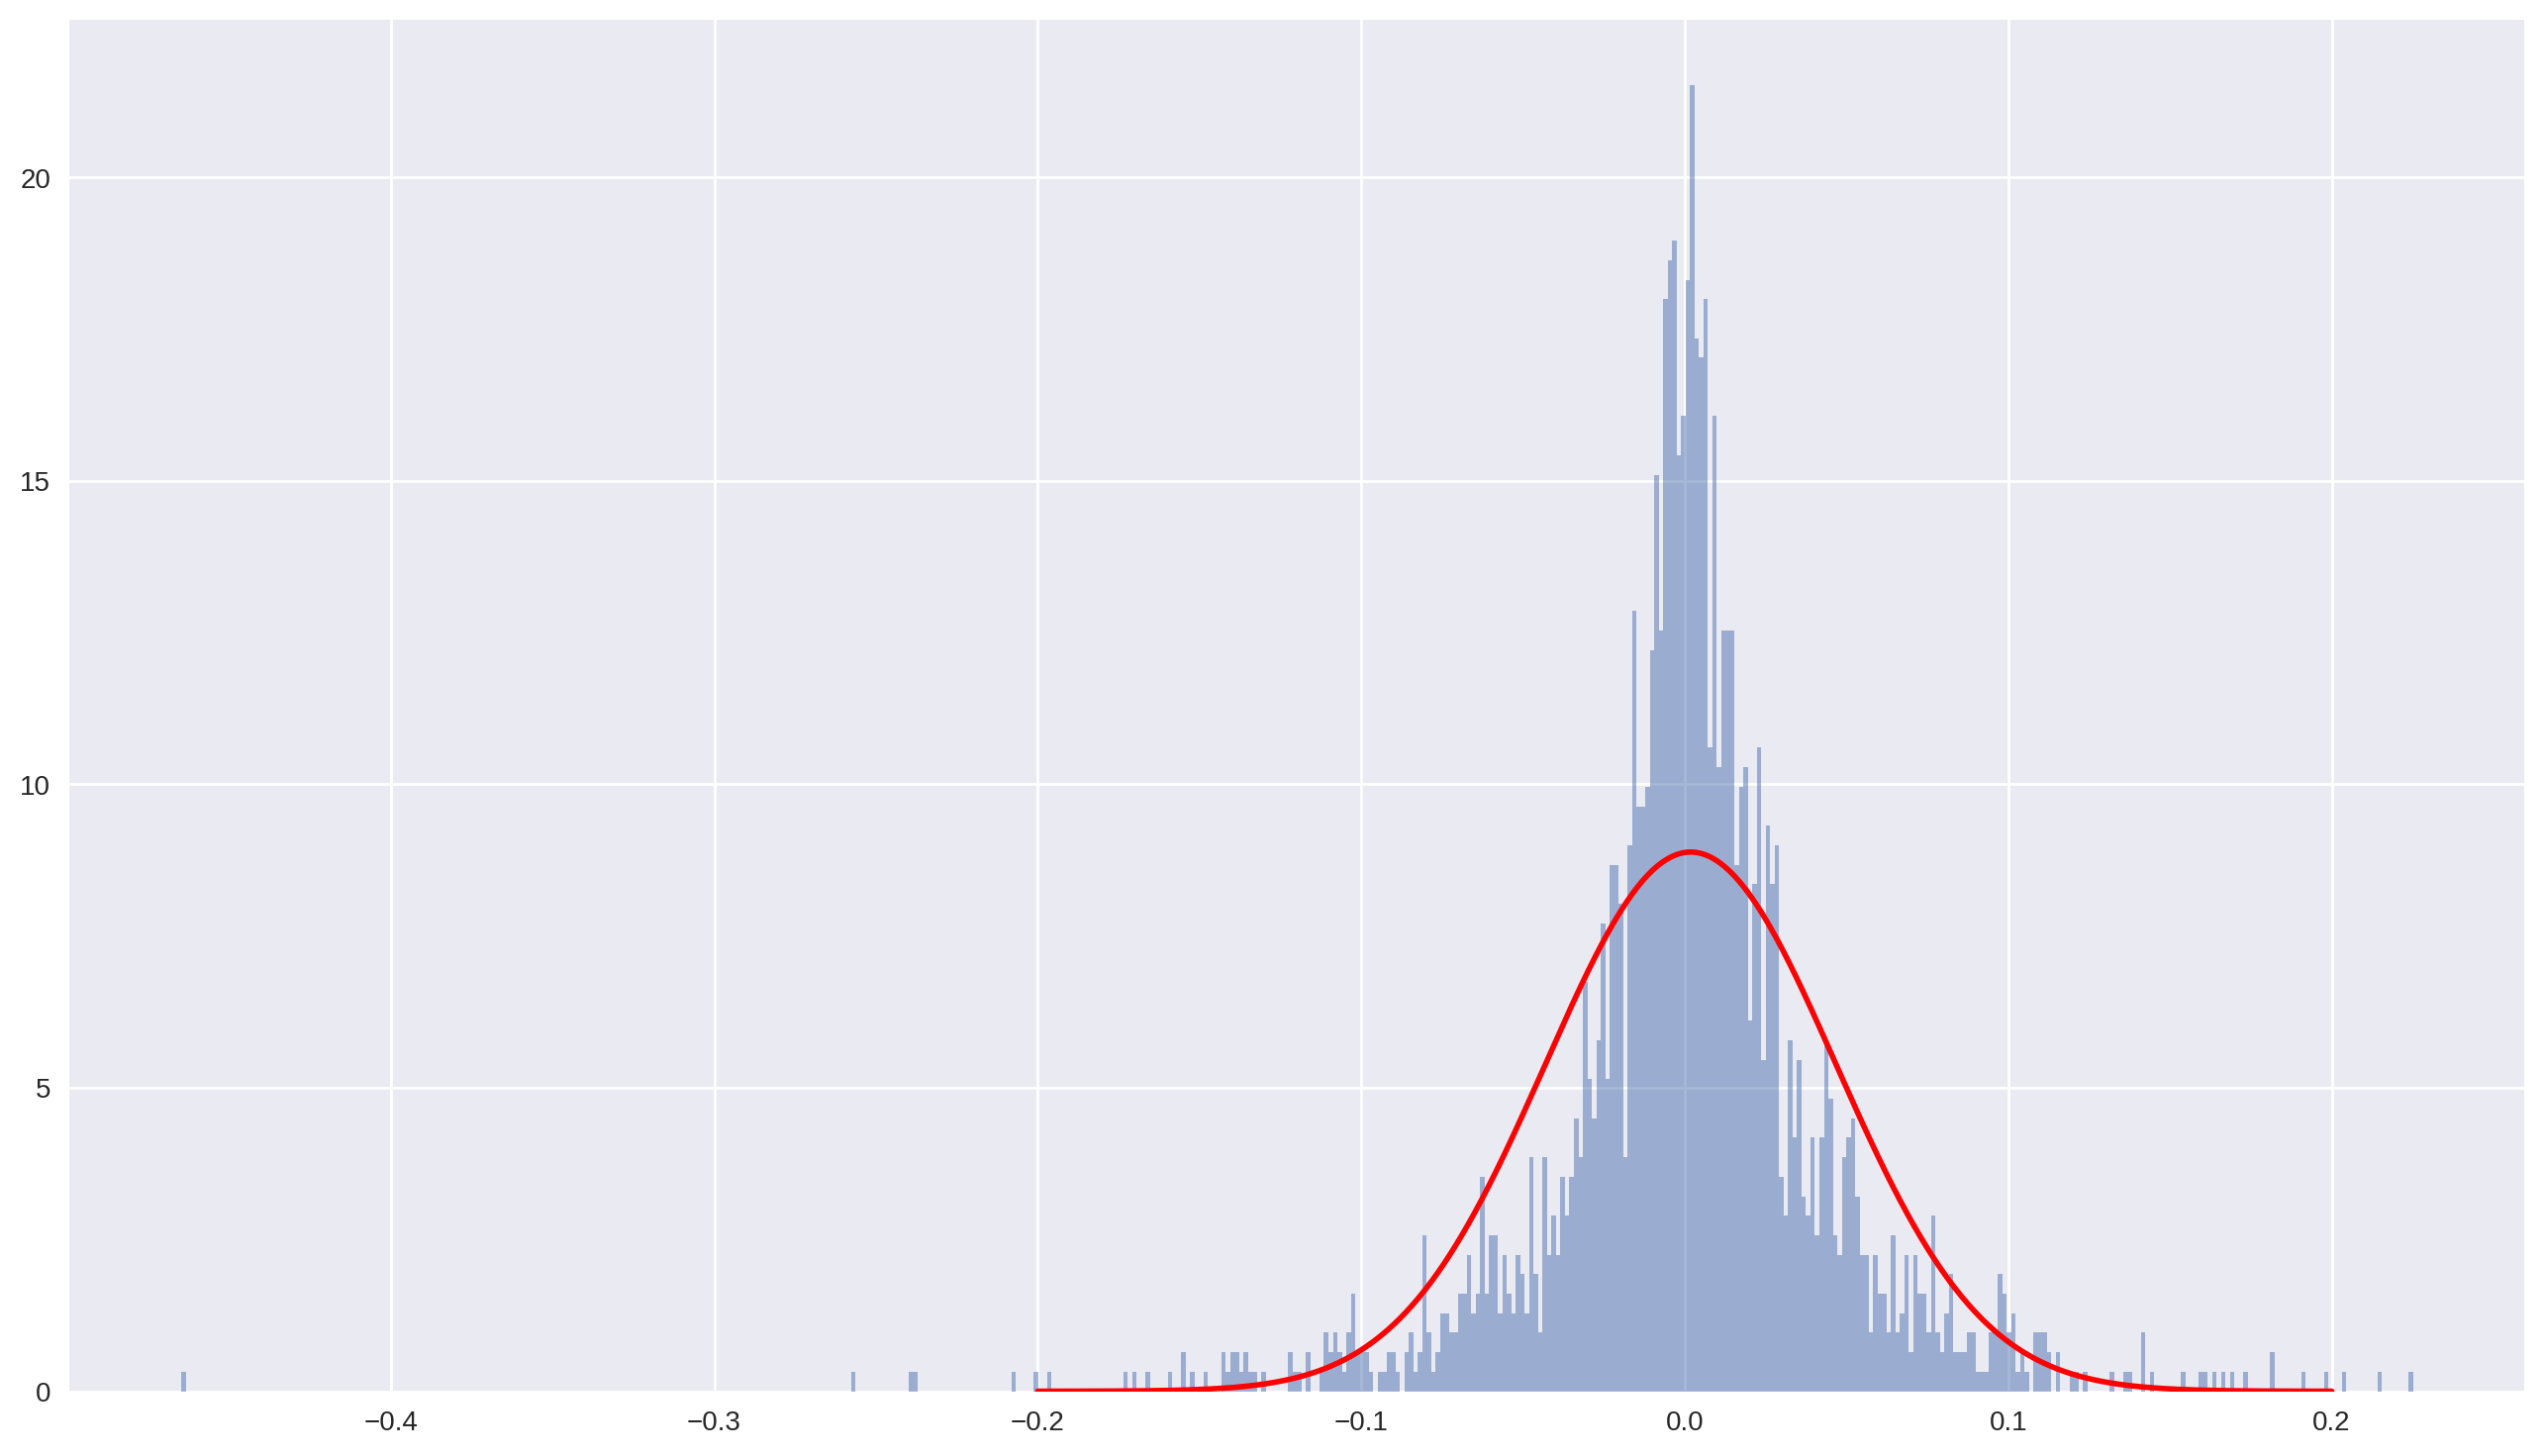

In [65]:
plt.hist(ret_close_df['BTC-USD'], bins=500, density=True, alpha=0.5, label='AAPL');
# Crear el gráfico
plt.plot(x, pdf_normal, 'r-', label='Distribución Normal', linewidth=2)

In [66]:
skewness = ret_close_df['BTC-USD'].skew()

# Imprimir el resultado
print(f"Coeficiente de Asimetría (Skewness): {skewness}")

print(f"Coeficiente de Curtosis (Kurtosis): {ret_close_df['BTC-USD'].kurtosis()}")

Coeficiente de Asimetría (Skewness): -0.65565958490211
Coeficiente de Curtosis (Kurtosis): 9.018971773307502


In [38]:
datos_graf = pd.DataFrame()
datos_graf['APPL'] = ret_close_df['AAPL']
datos_graf['IEF'] = ret_close_df['IEF']
datos_graf['BTC-USD'] = ret_close_df['BTC-USD']

# Crear una figura interactiva con histogramas y KDE superpuestos
fig = px.histogram(datos_graf, x=datos_graf.columns, marginal='rug', opacity=0.7, nbins=10, title='Histogramas con KDE Superpuestos')
fig.update_traces(histfunc='probability density')
fig.update_layout(barmode='overlay')

# Mostrar la figura interactiva
fig.show()


ValueError: 
    Invalid value of type 'builtins.str' received for the 'histfunc' property of histogram
        Received value: 'probability density'

    The 'histfunc' property is an enumeration that may be specified as:
      - One of the following enumeration values:
            ['count', 'sum', 'avg', 'min', 'max']

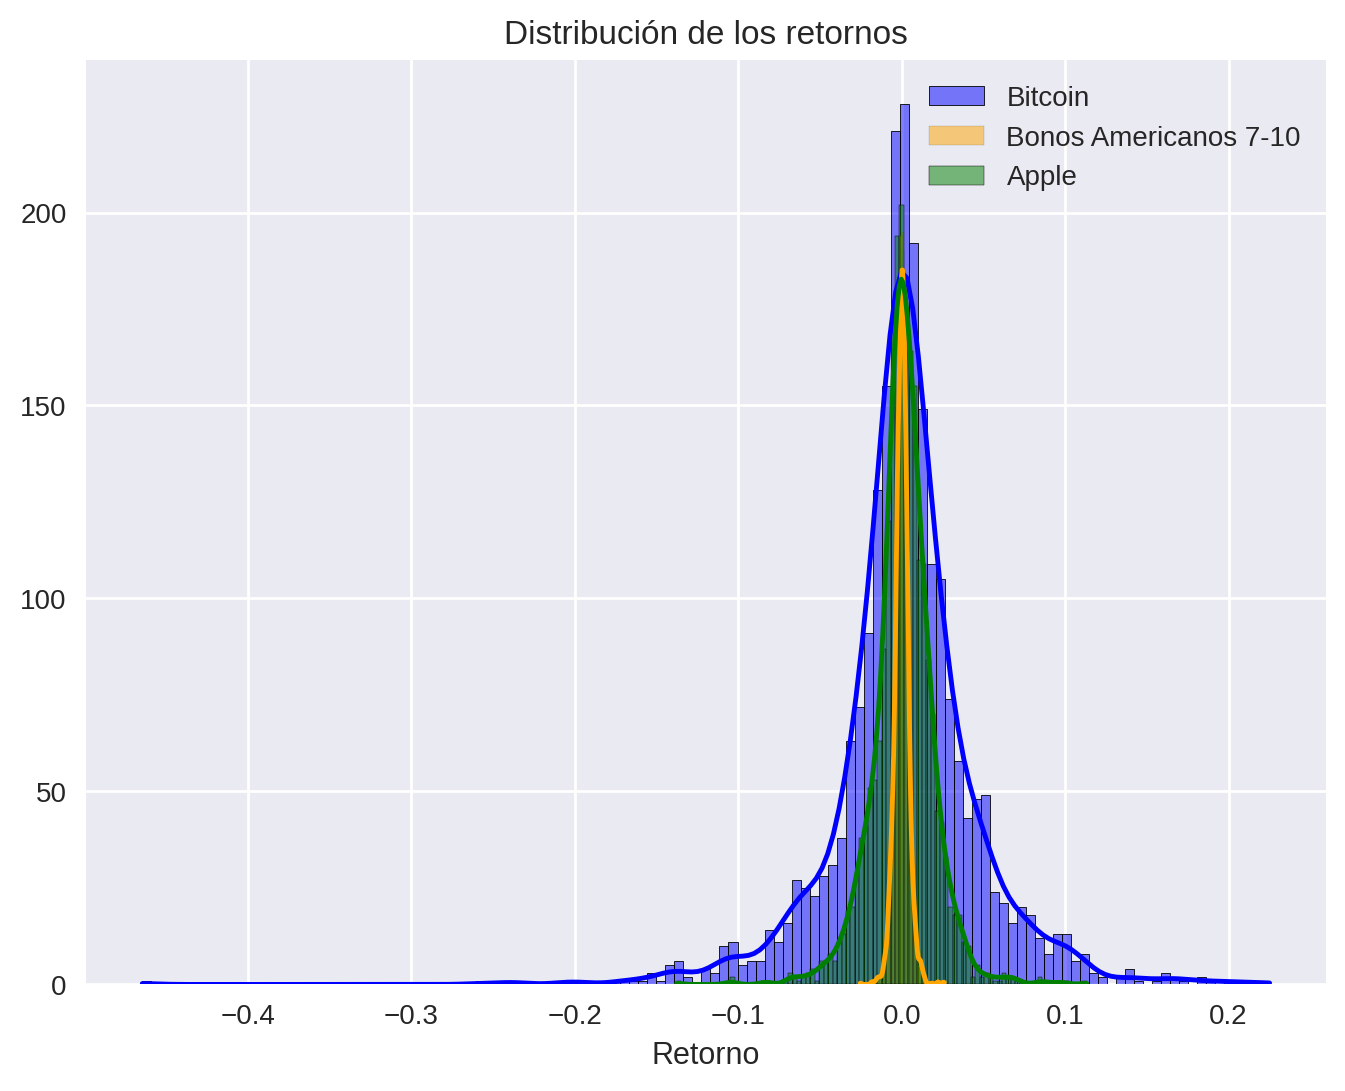

In [36]:
# Crear una figura
plt.figure(figsize=(8, 6))

# Usar seaborn para trazar histogramas y KDE superpuestos
sns.histplot(ret_close_df.loc[:, 'BTC-USD'], kde=True, color='blue', label='Bitcoin')
sns.histplot(ret_close_df.loc[:, 'IEF'], kde=True, color='orange', label='Bonos Americanos 7-10')
sns.histplot(ret_close_df.loc[:, 'AAPL'], kde=True, color='green', label='Apple')  

# Configurar etiquetas y leyenda
plt.xlabel('Retorno')
plt.ylabel('')
plt.title('Distribución de los retornos')
plt.legend()

# Mostrar el gráfico
plt.show()

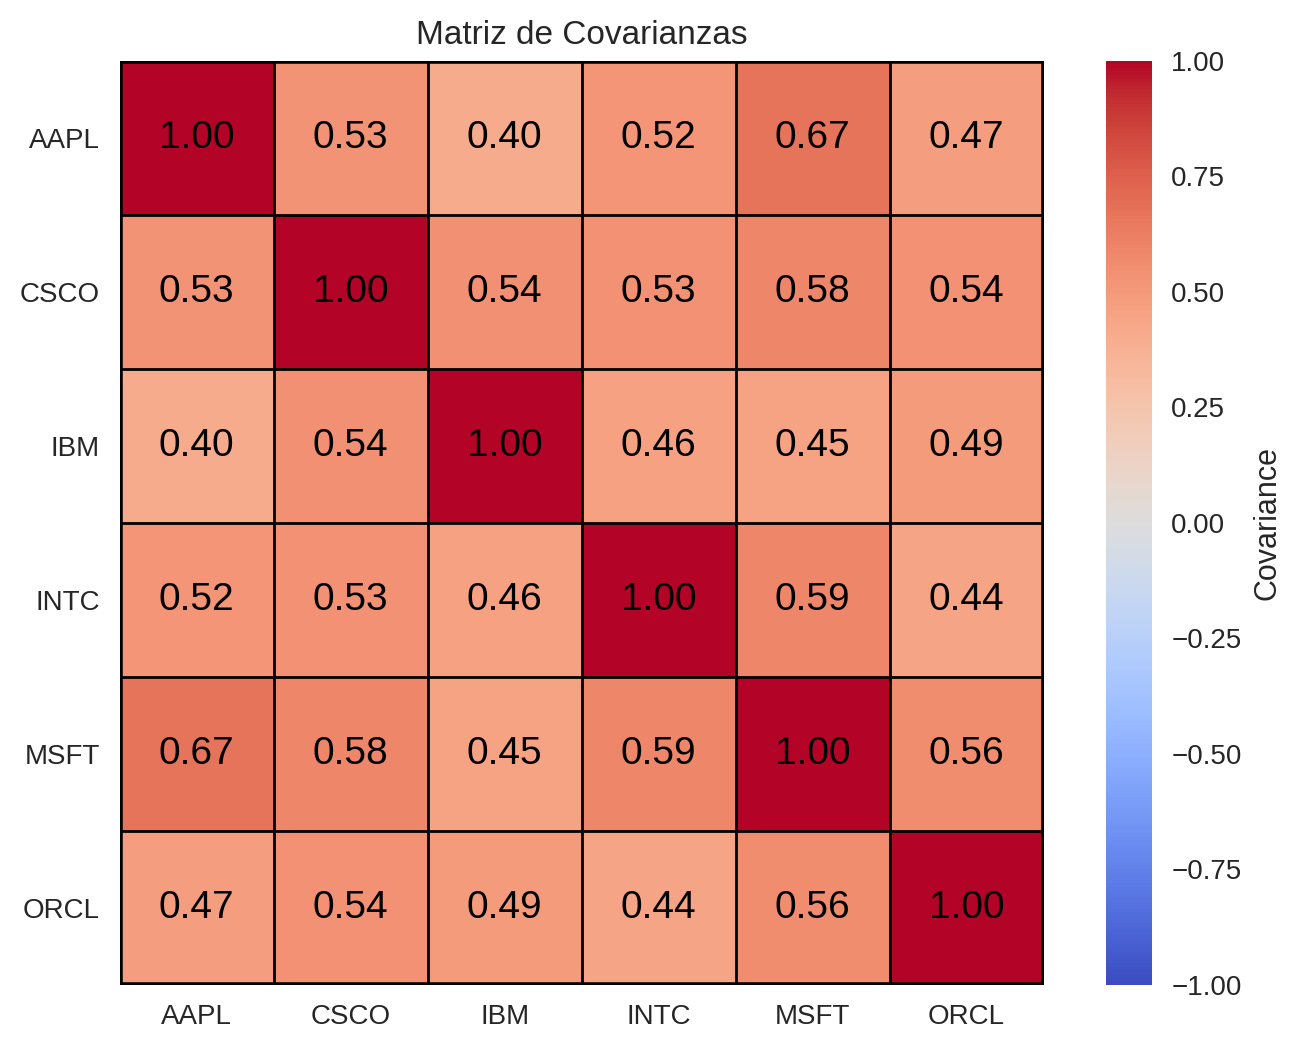

0

In [5]:
# Calcular la matriz de covarianzas
mat_cov_corr = ret_close_df_corr.corr()

dibuja_covar(mat_cov_corr)

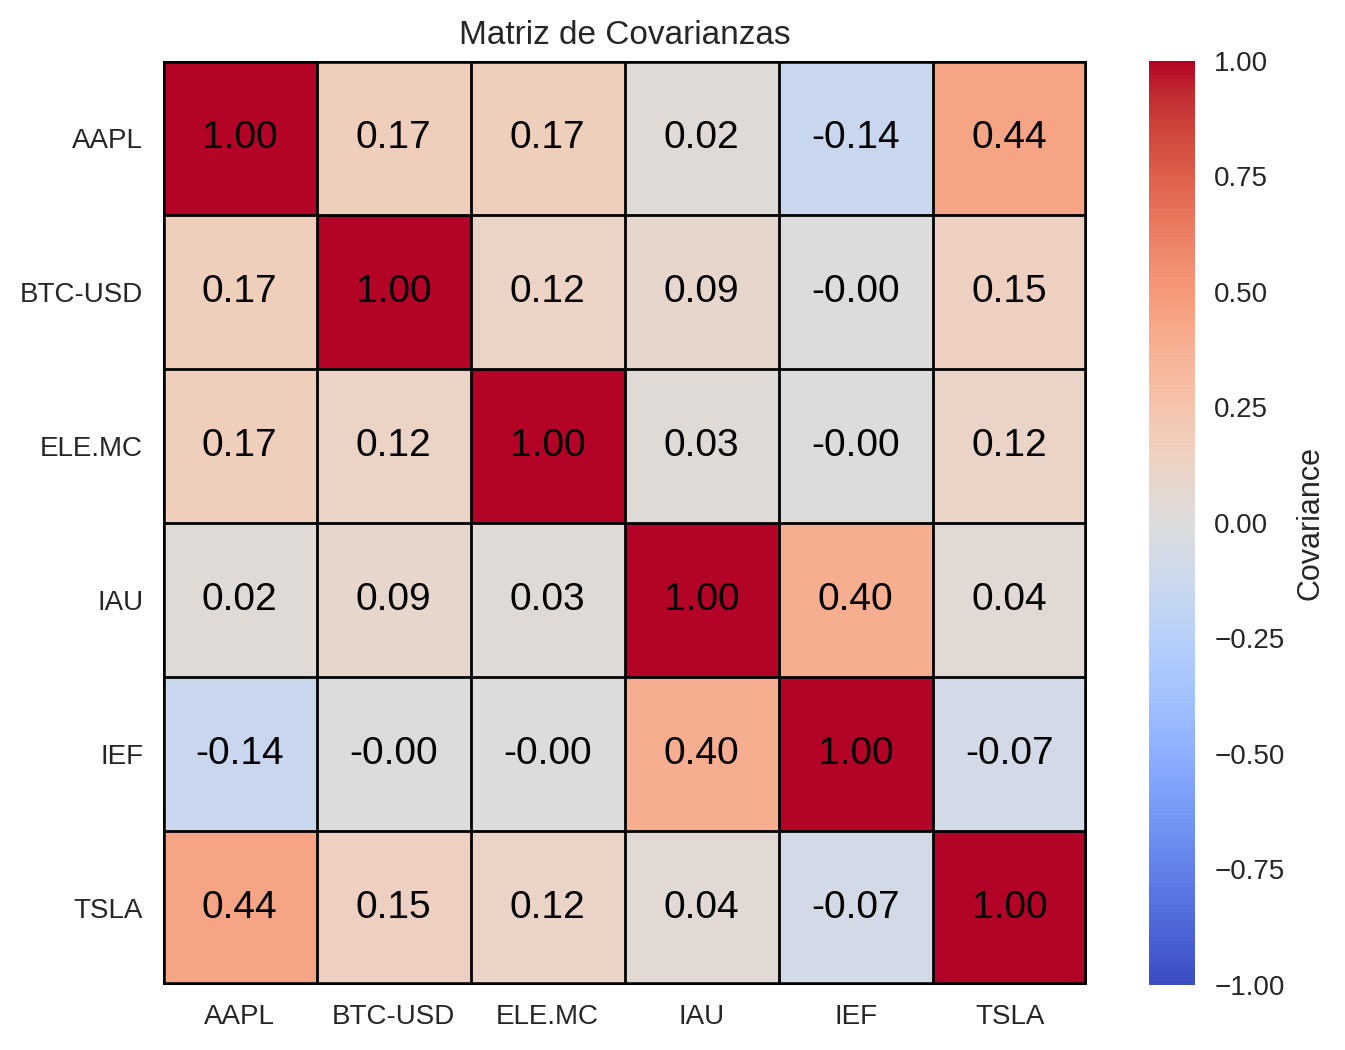

0

In [7]:
# Calcular la matriz de covarianzas
mat_cov = ret_close_df.corr()

dibuja_covar(mat_cov)

In [49]:
ret_close_df.cov()

,AAPL,BTC-USD,ELE.MC,IAU,IEF,TSLA
AAPL,0.000340,1.385478e-04,4.323644e-05,0.000004,-1.049811e-05,0.000289
BTC-USD,0.000139,2.017109e-03,7.512420e-05,0.000036,-8.921002e-08,0.000233
ELE.MC,0.000043,7.512420e-05,1.949590e-04,0.000003,-8.547396e-08,0.000058
IAU,0.000004,3.551070e-05,3.144680e-06,0.000080,1.478439e-05,0.000014
IEF,-0.000010,-8.921002e-08,-8.547396e-08,0.000015,1.726258e-05,-0.000011
TSLA,0.000289,2.329627e-04,5.761210e-05,0.000014,-1.096431e-05,0.001262


In [26]:
data_df = yf.Ticker(company).history(period='5y',interval='1d')
data_df.head(3)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-10-05 00:00:00-04:00,54.581250,54.688994,52.814230,53.702526,134322000,0.0,0.0
2018-10-08 00:00:00-04:00,53.204503,53.824634,52.723239,53.578018,118655600,0.0,0.0
2018-10-09 00:00:00-04:00,53.546886,54.416031,53.214074,54.320255,107564000,0.0,0.0


Hacer gráfico sencillo de los precios de cierre de las acciones de Apple

<Axes: title={'center': 'AAPL Stock Price'}, xlabel='Date'>

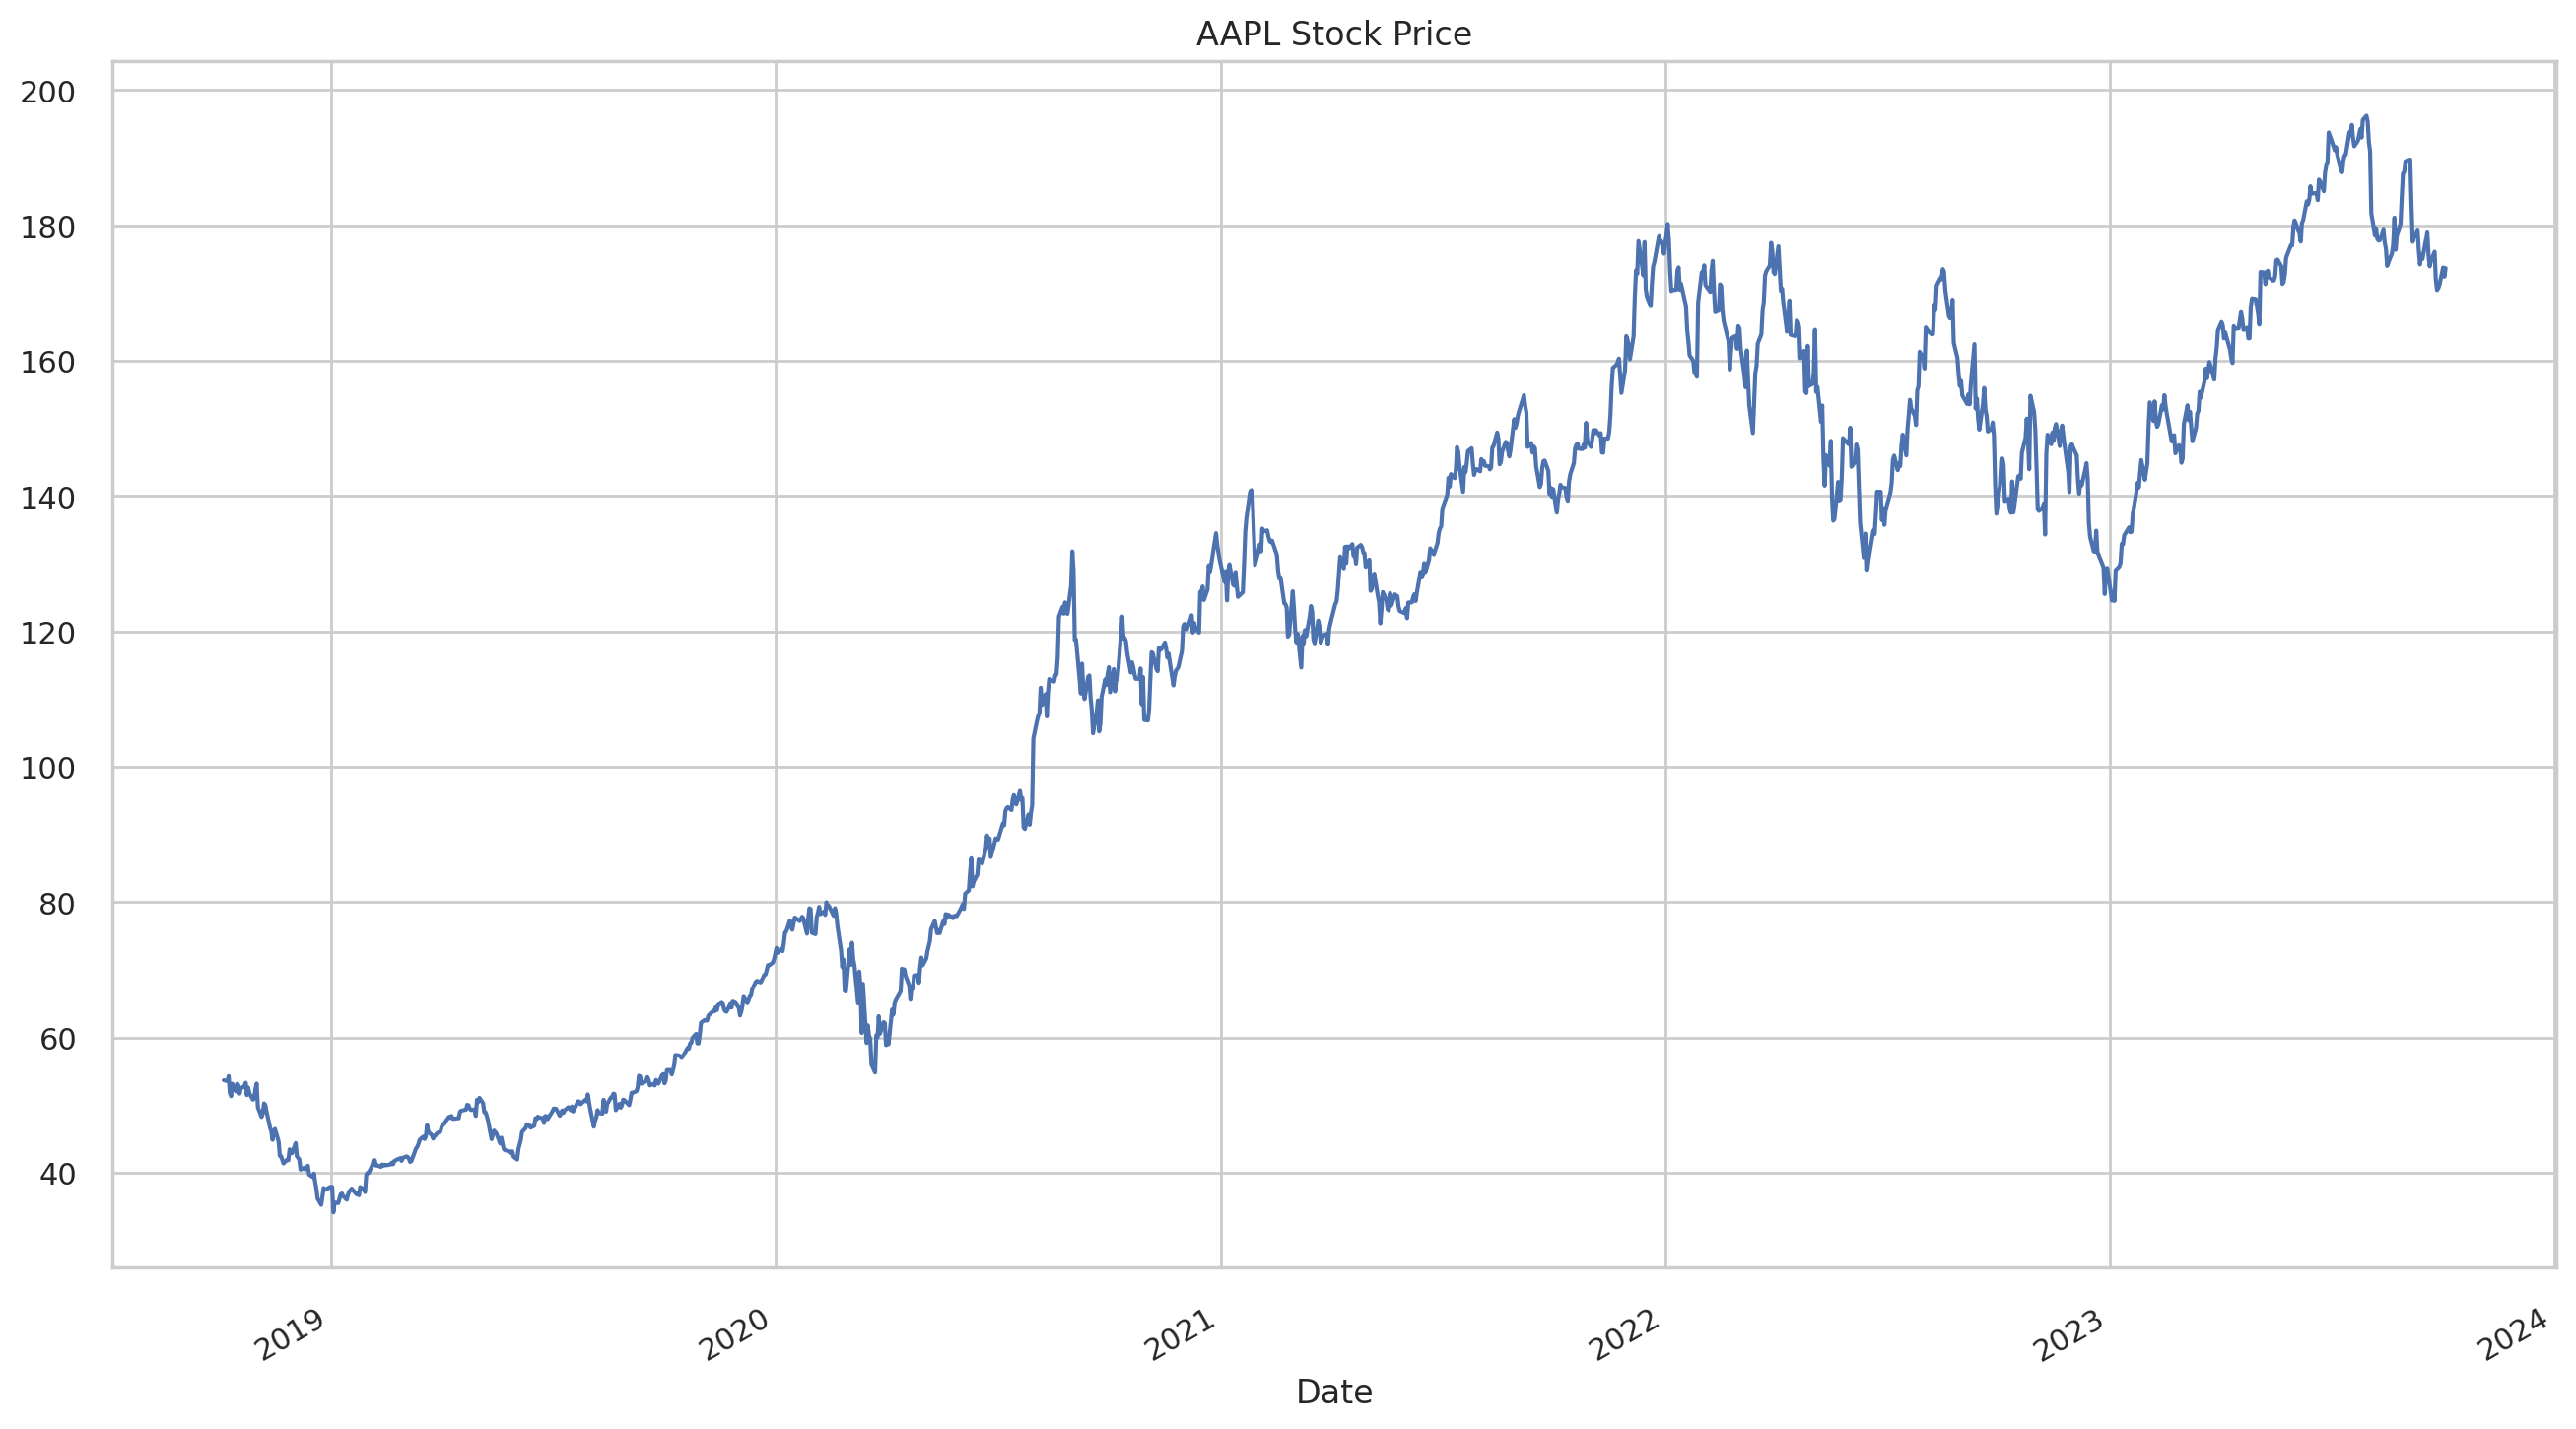

In [27]:
data_df.loc[:, 'Close'].plot(title=f'{company} Stock Price')

Hacer un gráfico de velas de los precios de cierre de las acciones de Apple

In [5]:
fig = go.Figure(data=[go.Candlestick(x=data_df.index,
                open=data_df['Open'],
                high=data_df['High'],
                low=data_df['Low'],
                close=data_df['Close'])])

fig.update_layout(title = f'{company}: Candlestick Price Chart', xaxis_tickfont_size = 14)
fig.update_layout(xaxis_rangeslider_visible = False)
    
fig.show()

Hacer un gráfico con precios de cierre y volumen de las acciones de Apple

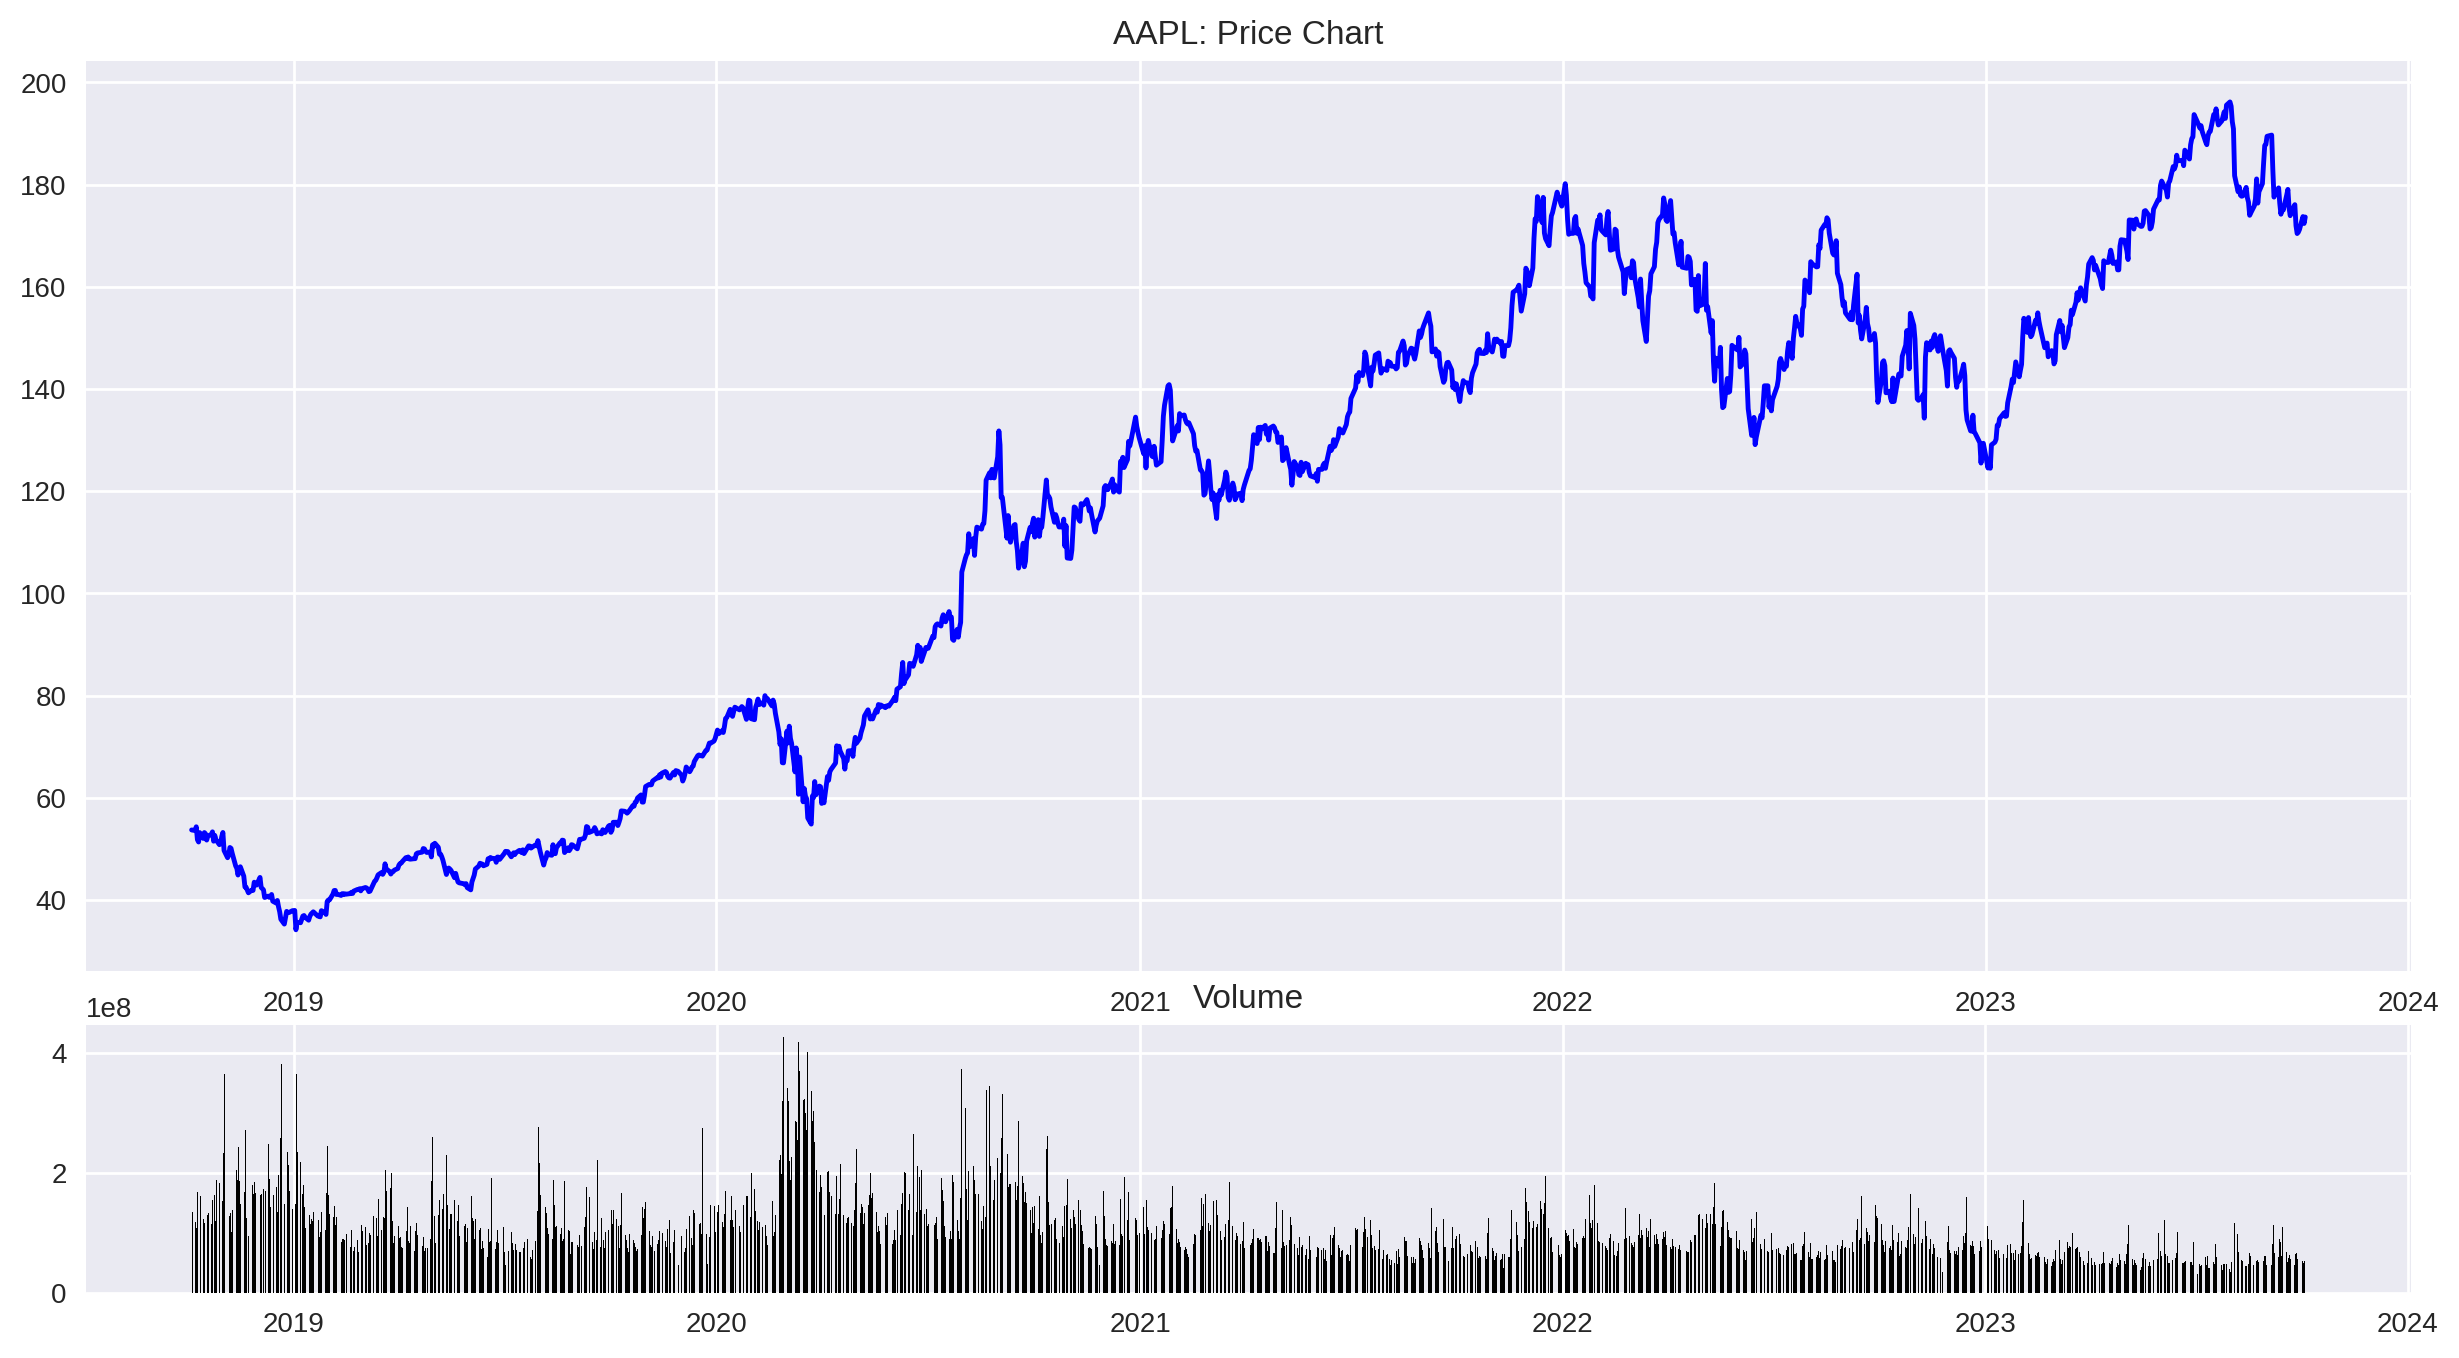

In [6]:
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(data_df.index, data_df["Close"], color='blue')
plt.title(f'{company}: Price Chart')

bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(data_df.index, data_df['Volume'], color='black')
plt.title('Volume')

plt.gcf().set_size_inches(15,8)

## Convertir precios en rendimientos

Existen dos formas de convertir precios en rendimientos:

1. Rendimientos aritméticos: $r_t = \frac{P_t}{P_{t-1}} - 1$

2. Rendimientos logarítmicos: $r_t = ln(\frac{P_t}{P_{t-1}})$ 

Ambos rendimientos son equivalentes cuando los rendimientos son pequeños. Veamos como se comportan los rendimientos aritméticos y logarítmicos para distintos valores de rendimiento:

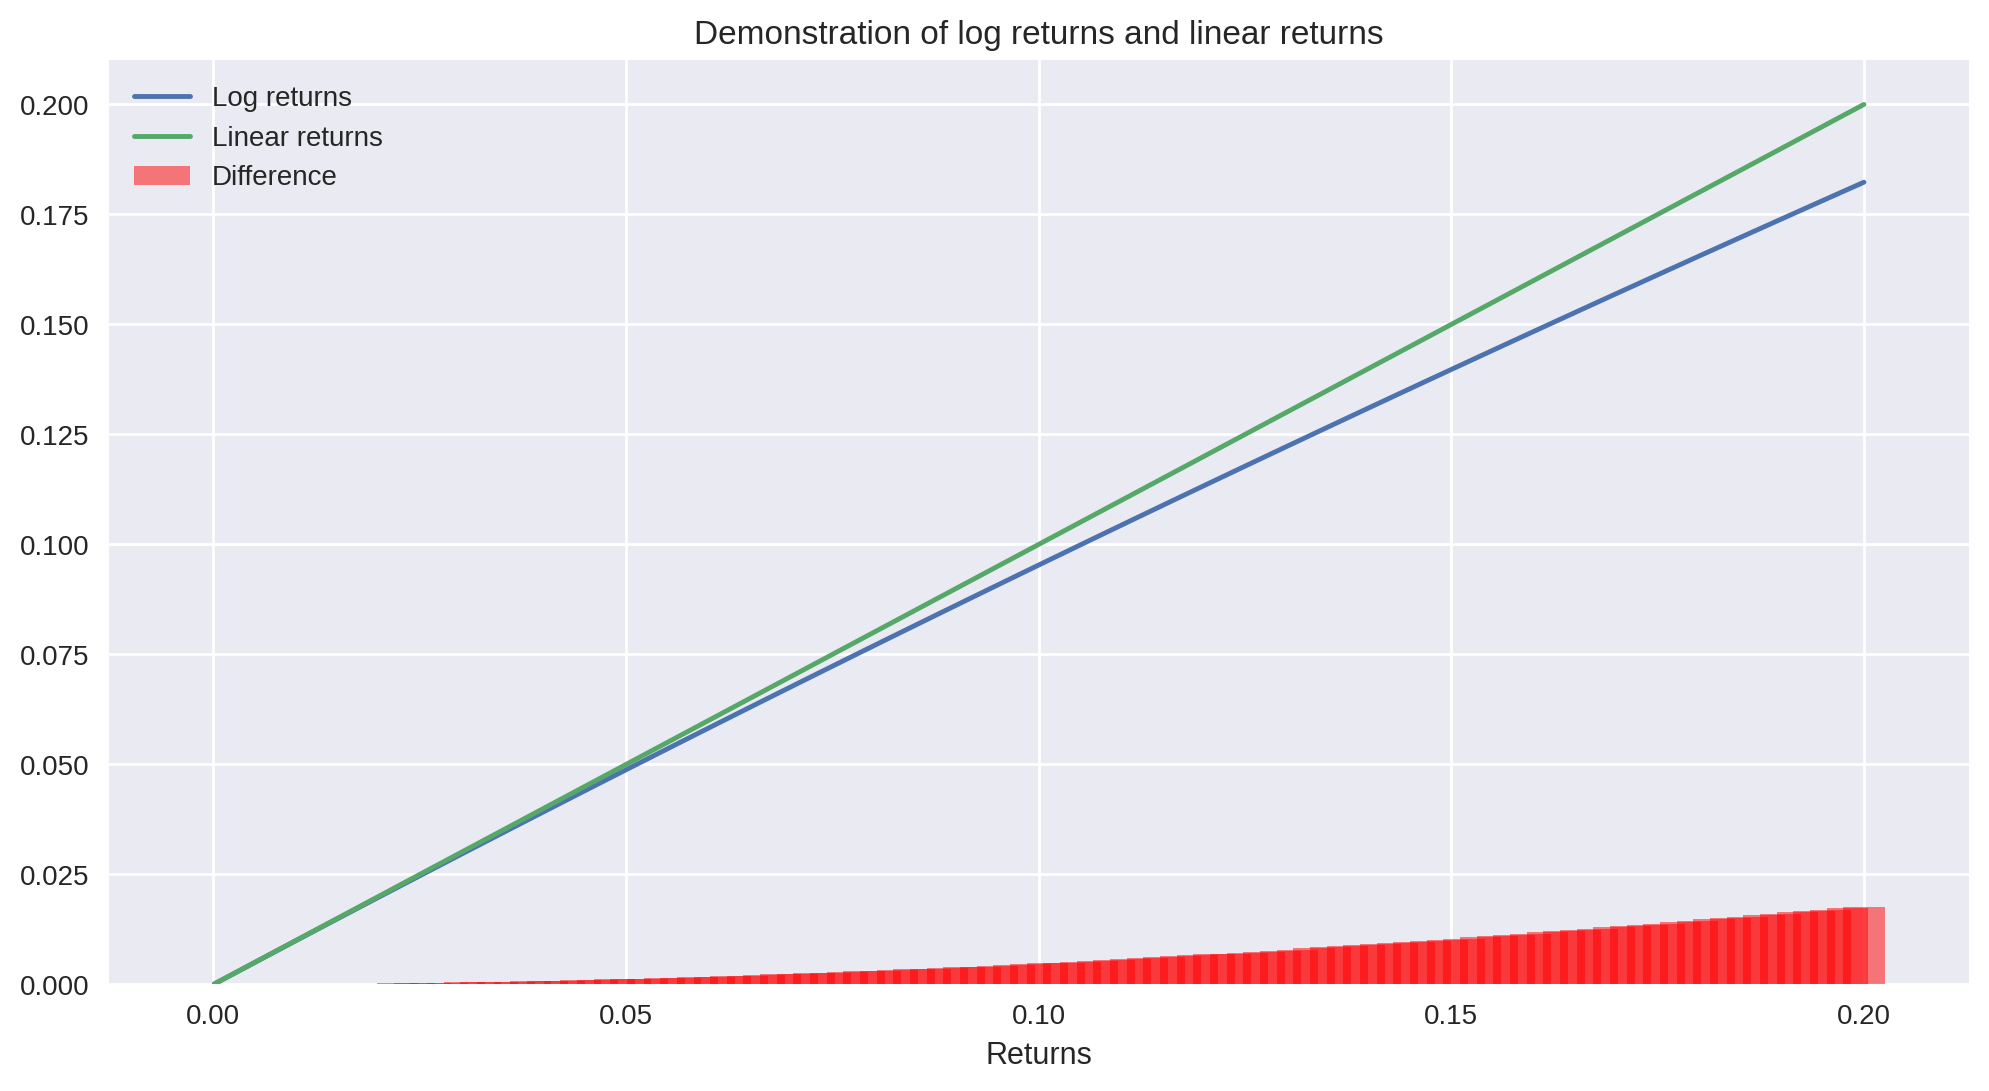

In [9]:
x_returns = np.linspace(0.0001, .2, 100) # Generate 100 numbers between 0.0001 and 0.2
y_returns = np.log(1 + x_returns) # Calculate the logarithmic returns from the linear returns

# Plot the linear and log returns
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(x_returns, y_returns, label='Log returns') # Plot the log returns
plt.plot(x_returns, x_returns, label='Linear returns') # Plot the linear returns
plt.bar(x_returns, x_returns-y_returns, width=0.005, color='r', alpha=0.5, label='Difference', ) # Plot the difference between the two returns
plt.legend()
plt.xlabel('Returns')
plt.title('Demonstration of log returns and linear returns');

Seleccionamos los precios de cierre

In [28]:
precios_df = data_df.loc[:, 'Close']
precios_df = pd.DataFrame(precios_df)
precios_df.head(2)

,Close
Date,
2018-10-05 00:00:00-04:00,53.702526
2018-10-08 00:00:00-04:00,53.578018


Calculamos los retornos logarítmicos

In [29]:
ret_df = np.log(precios_df).diff().dropna()
ret_df.head(2)

,Close
Date,
2018-10-08 00:00:00-04:00,-0.002321
2018-10-09 00:00:00-04:00,0.013758


In [12]:
# Crear una figura interactiva de Plotly
fig = px.line(ret_df, x=ret_df.index.values, y='Close', title='Gráfica de Retornos Diarios')

# Personaliza el diseño de la gráfica
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Retornos',
    template='plotly',  # Puedes elegir un tema de diseño que te guste
    hovermode='x',  # Muestra información al pasar el cursor sobre la gráfica
    showlegend=True  # Muestra la leyenda si tienes varias líneas
)

# Agregar etiquetas a los puntos de datos
fig.update_traces(mode='markers+lines', hovertemplate='%{y:.2f}')

# Mostrar la gráfica interactiva
fig.show()

In [14]:
import scipy.stats as stats

In [15]:
# Calcular la media y la desviación estándar de los retornos
media_retornos = ret_df['Close'].mean()
std_retornos = ret_df['Close'].std()


# Crear un histograma interactivo
fig = px.histogram(ret_df, x='Close', nbins=1000, title='Distribución de Retornos')

# Agregar la línea de la distribución normal
x = np.linspace(ret_df['Close'].min(), ret_df['Close'].max(), 1000)
pdf = stats.norm.pdf(x, loc=media_retornos, scale=std_retornos) * len(ret_df)
fig.add_scatter(x=x, y=pdf, mode='lines', name='Distribución Normal', line=dict(color='red'))

# Personalizar el diseño del histograma
fig.update_layout(
    xaxis_title='Retornos',
    yaxis_title='Frecuencia',
    template='plotly',  # Puedes elegir un tema de diseño que te guste
    showlegend=False  # No mostrar la leyenda en un histograma
)

# Mostrar el histograma interactivo
fig.show()

In [17]:
data_components = pd.read_excel('../data/SP500_comp_data.xlsx', index_col='Date', parse_dates=['Date']) # Precios de los componentes de SP500 que hay en la lista 
sp500 = pd.read_excel('../data/sp500.xlsx', index_col='Date', parse_dates=['Date']) # Precios del SP500

In [24]:
ret_components = np.log(data_components).diff()
ret_sp500 = np.log(sp500).diff().dropna()
ret_components.shape
ret_std = ret_components.std()
ret_std.max(), ret_std.min()

(0.052773917658164575, 0.012286880124569747)

In [27]:
pos_std_max

'NVR'

(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 5.000e+00,
        0.000e+00, 9.000e+00, 1.800e+01, 4.000e+01, 1.100e+02, 1.840e+02,
        1.285e+03, 5.778e+03, 7.440e+02, 1.510e+02, 8.300e+01, 2.300e+01,
        1.600e+01, 1.100e+01, 6.000e+00, 1.000e+00, 4.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

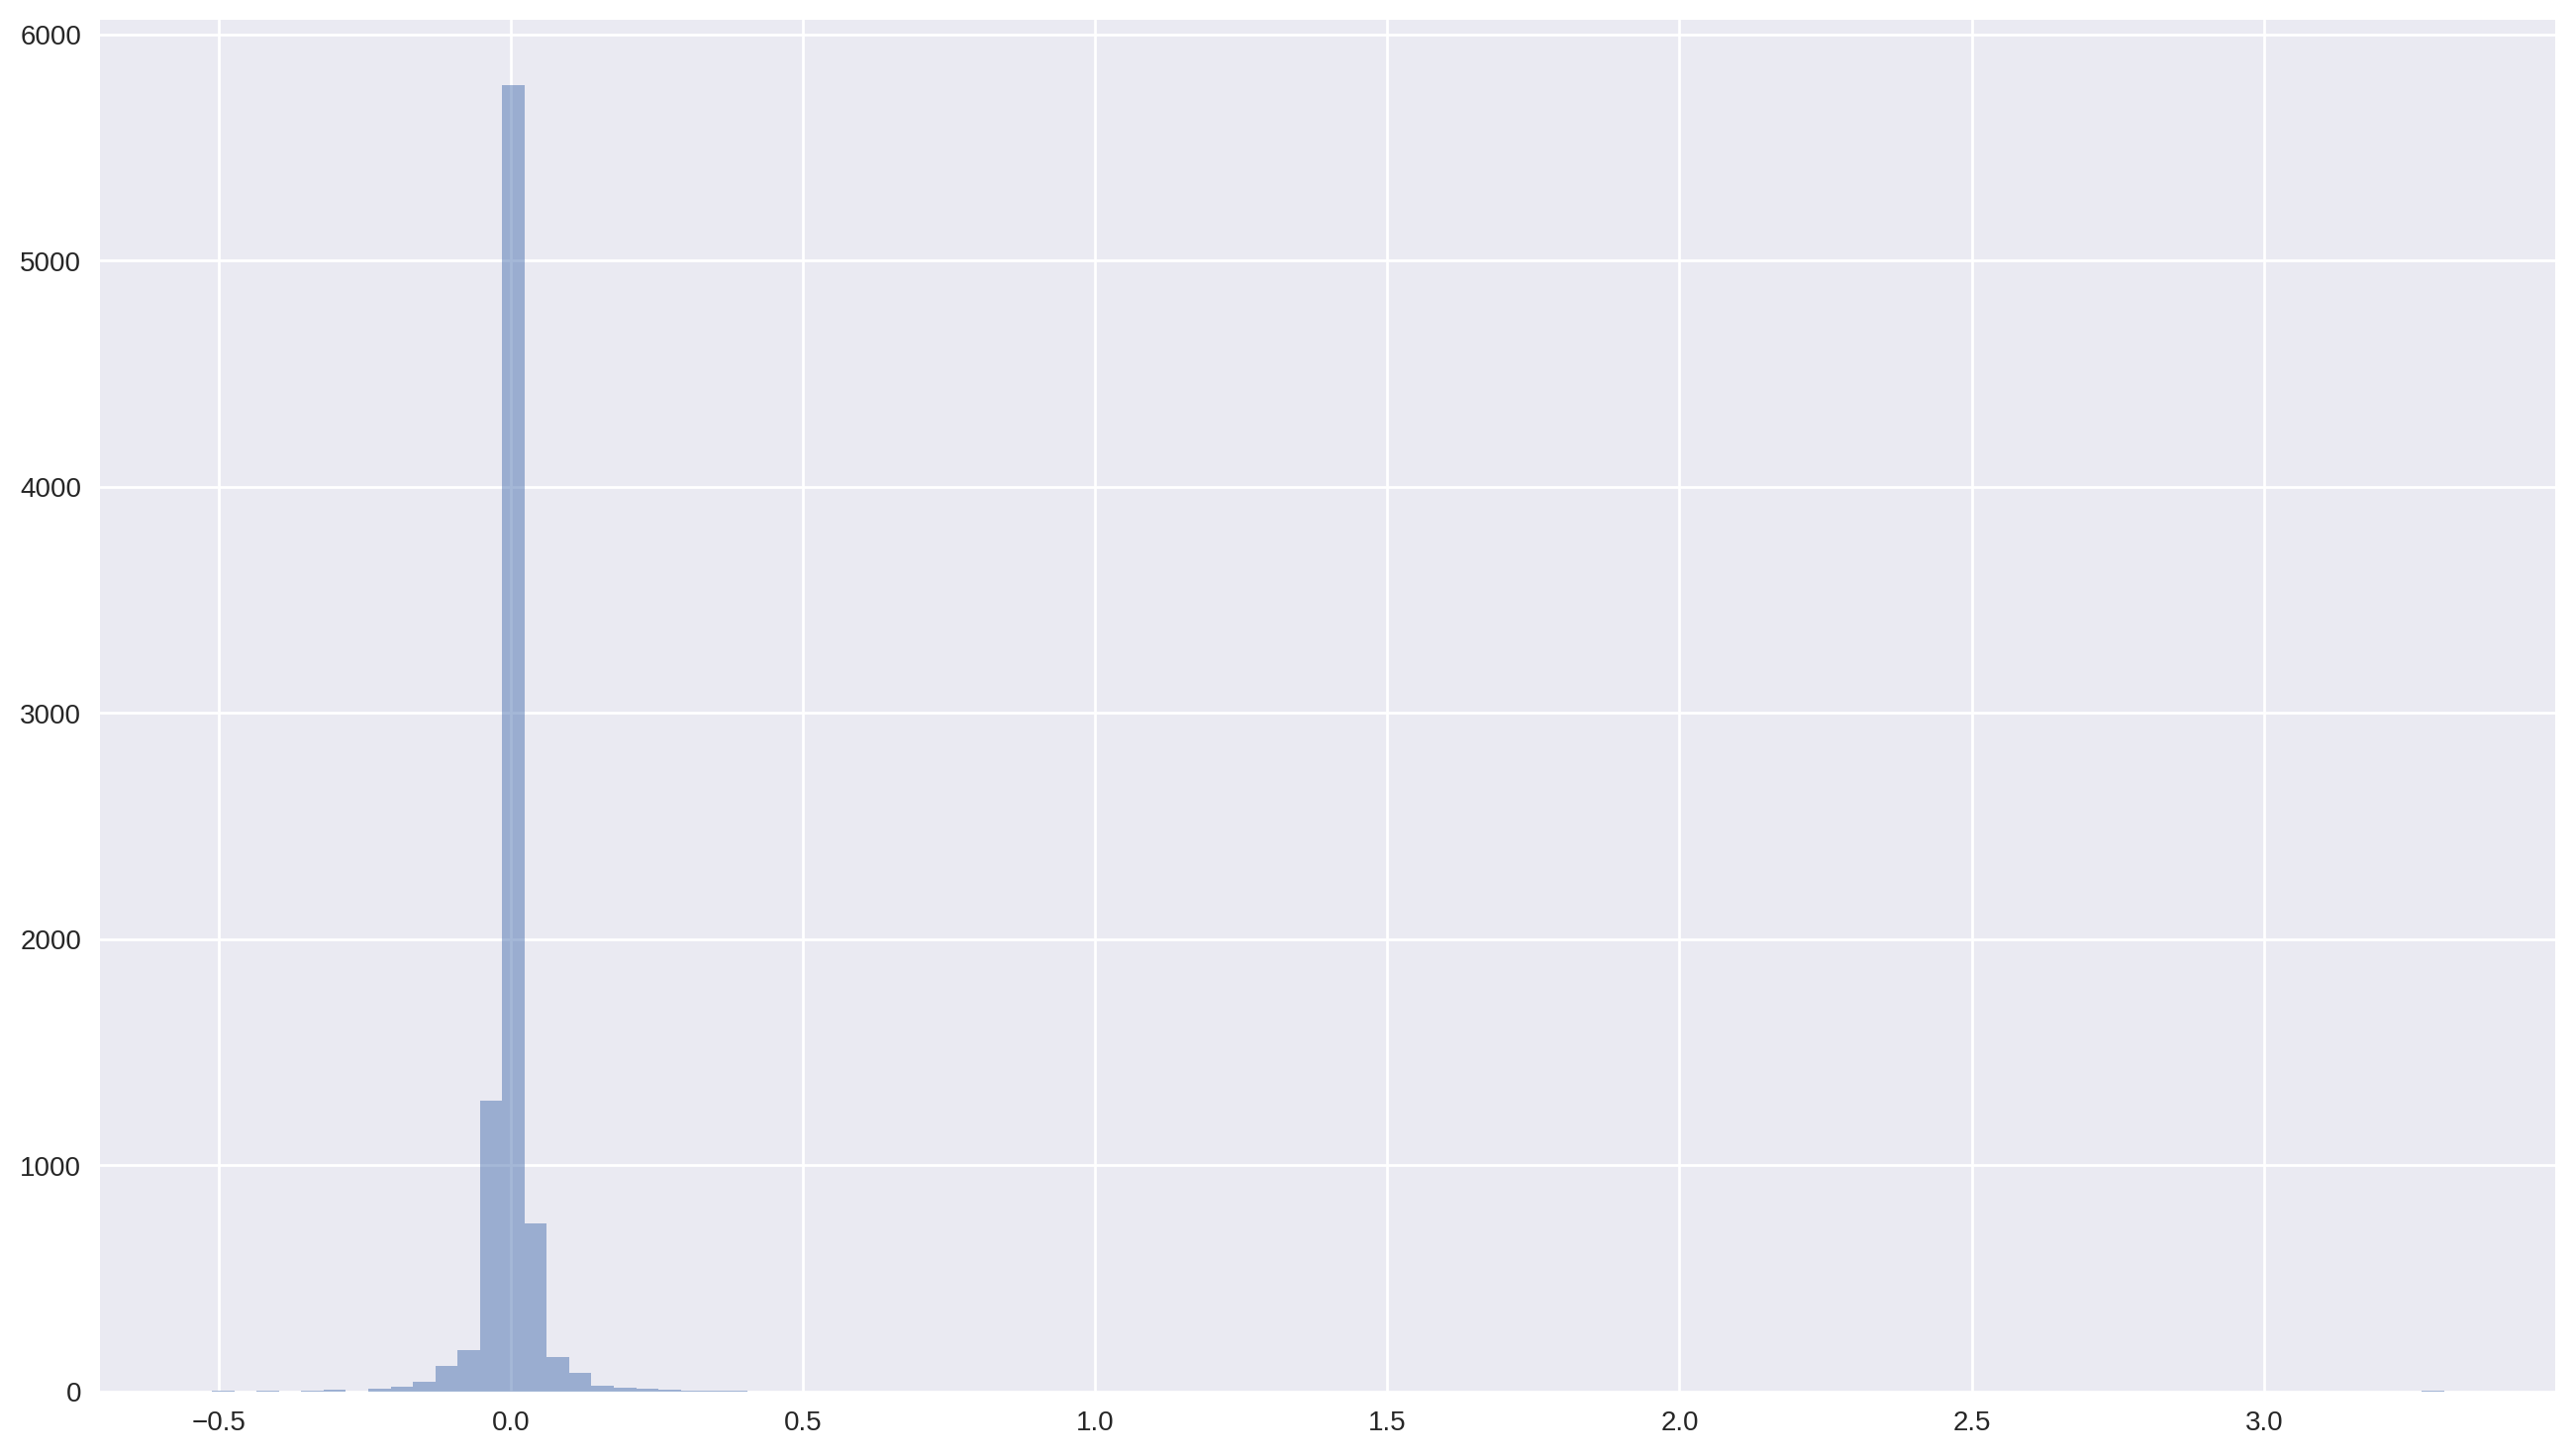

In [29]:
pos_std_max = ret_std.idxmax()
pos_std_min = ret_std.idxmin()

plt.hist(ret_components.loc[:, pos_std_max], bins=100, alpha=0.5, label='Max')
#plt.hist(ret_components.loc[:, pos_std_min], bins=100, alpha=0.5, label='Min')

In [19]:
ret_bitcoin.head(2)

,Adj Close
Date,
2014-09-18,-0.074643
2014-09-19,-0.072402


<Axes: ylabel='Count'>

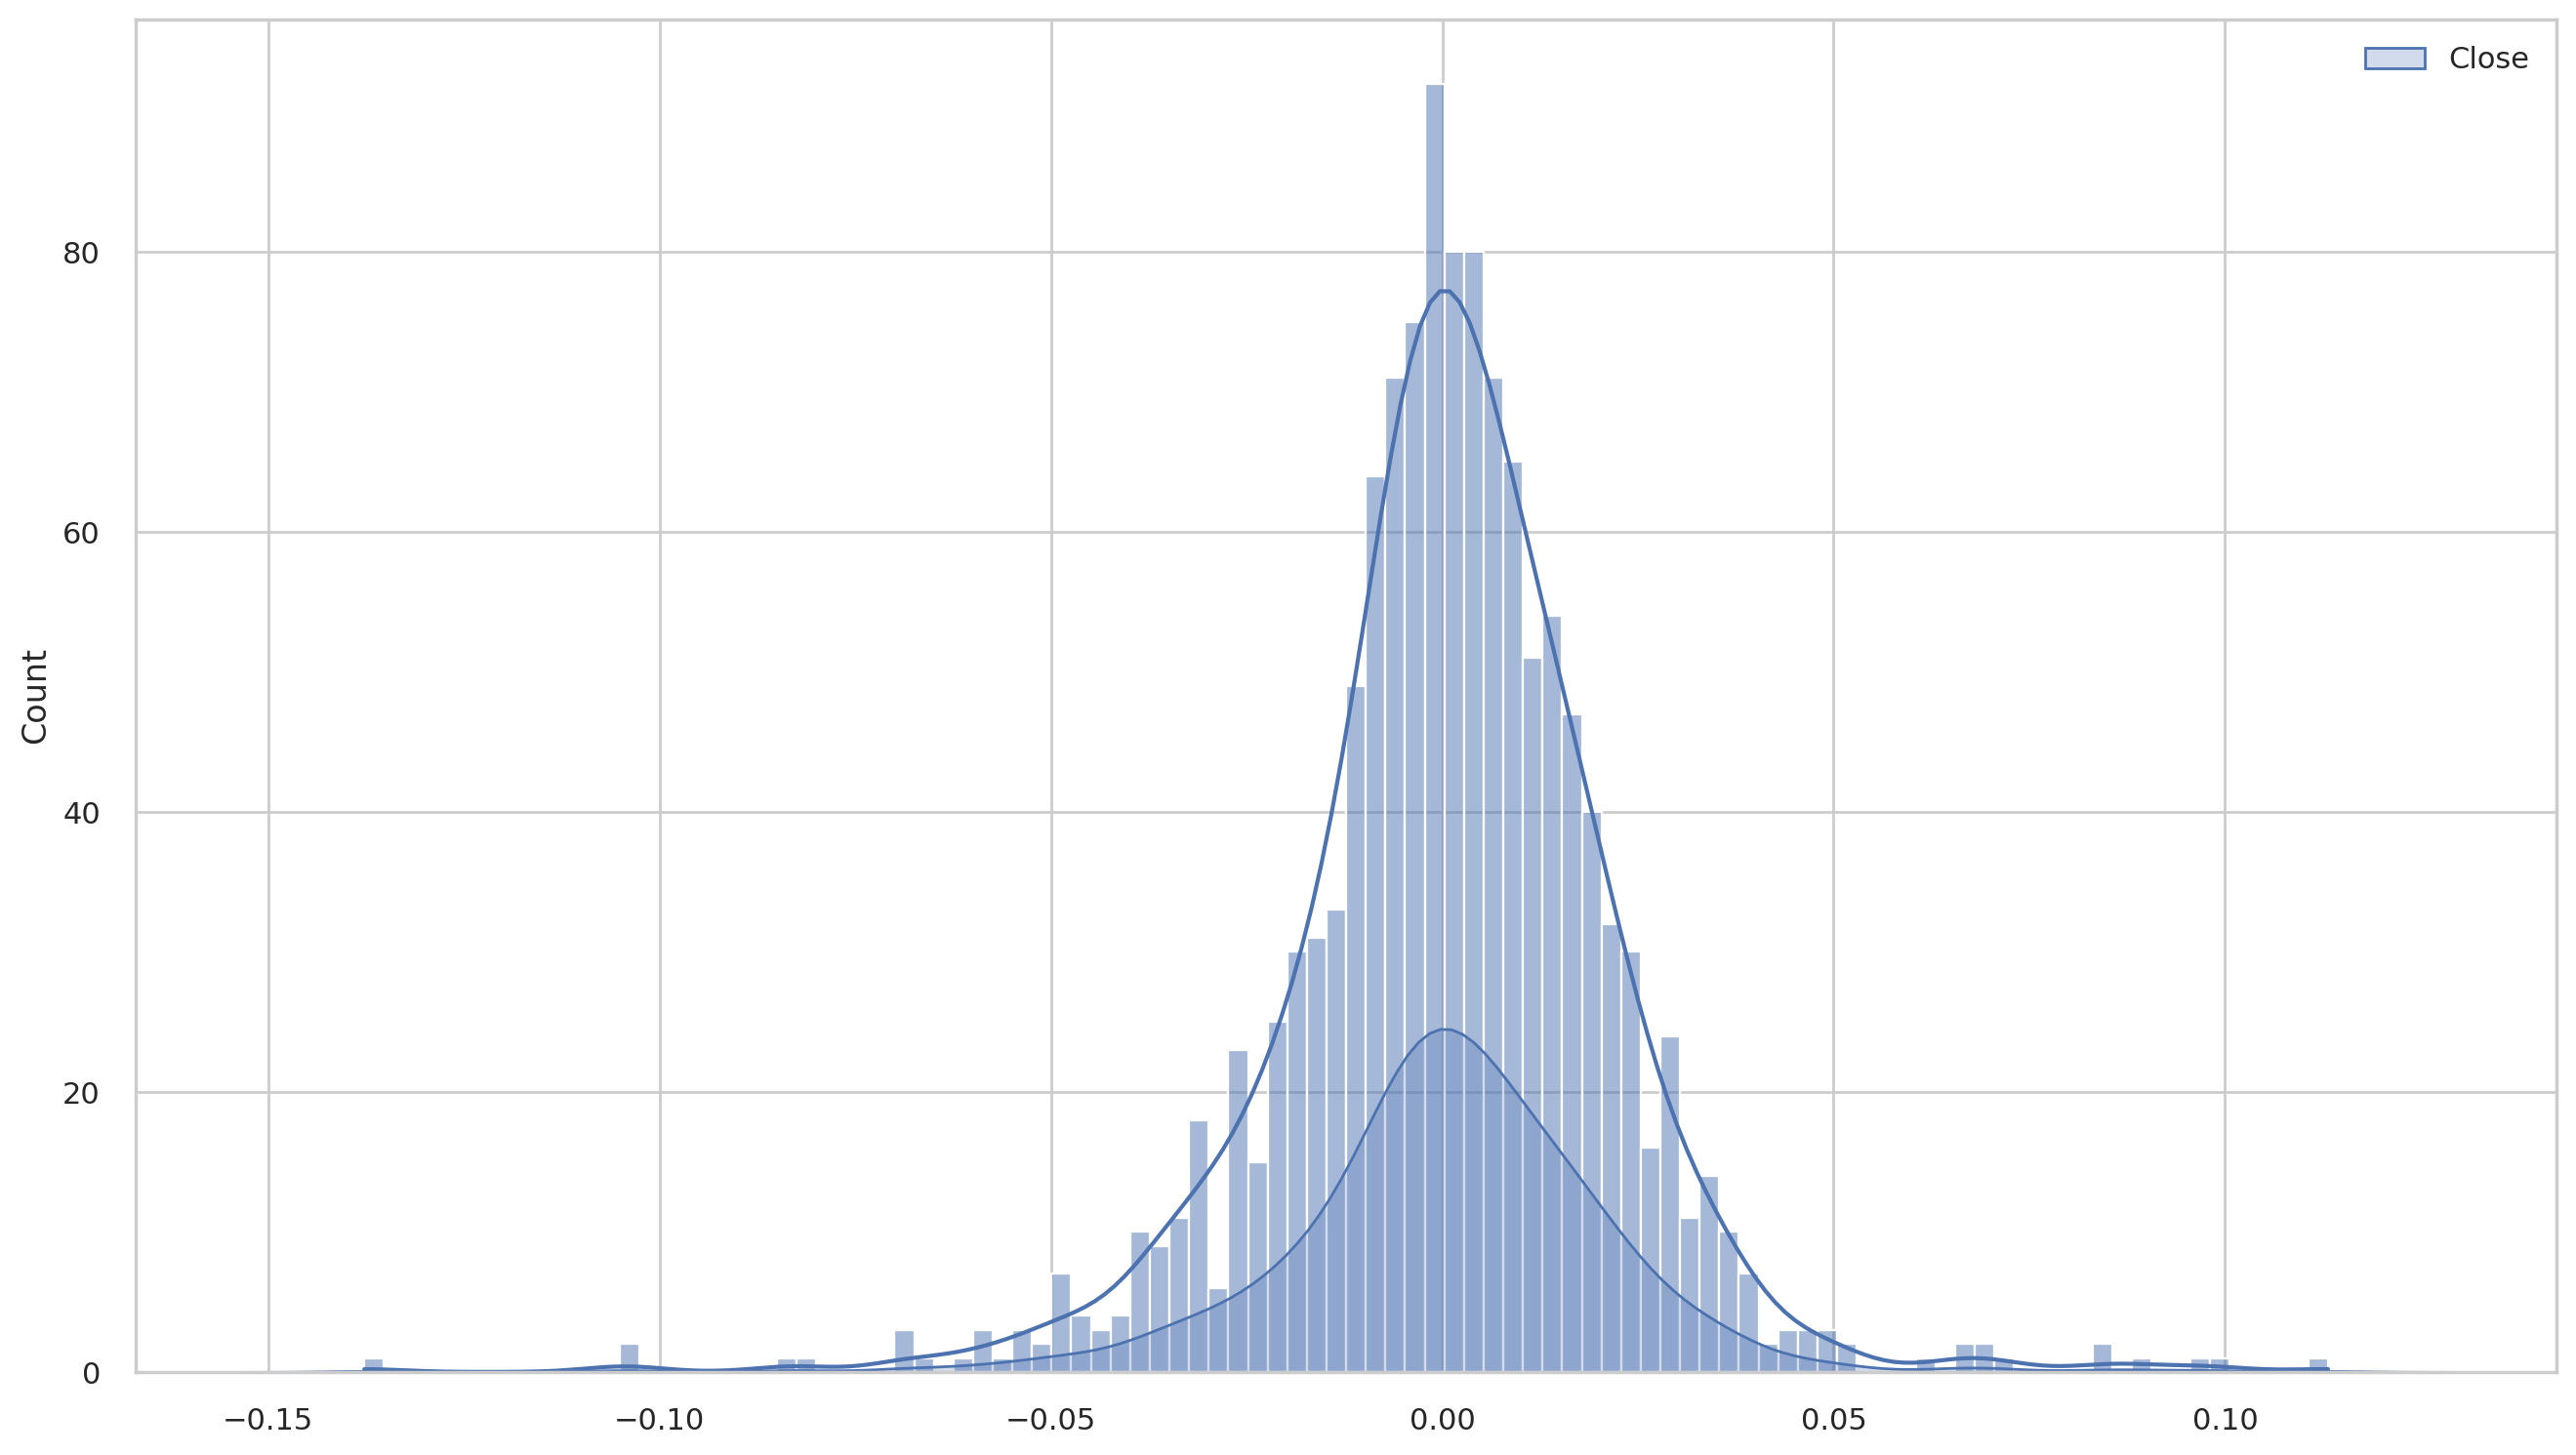

In [30]:
sns.set(style="whitegrid")  # Estilo del gráfico
sns.histplot(ret_df, bins=100, kde=True, color='skyblue')  # Histograma
sns.kdeplot(ret_df, shade=True, color="skyblue")

<Axes: ylabel='Count'>

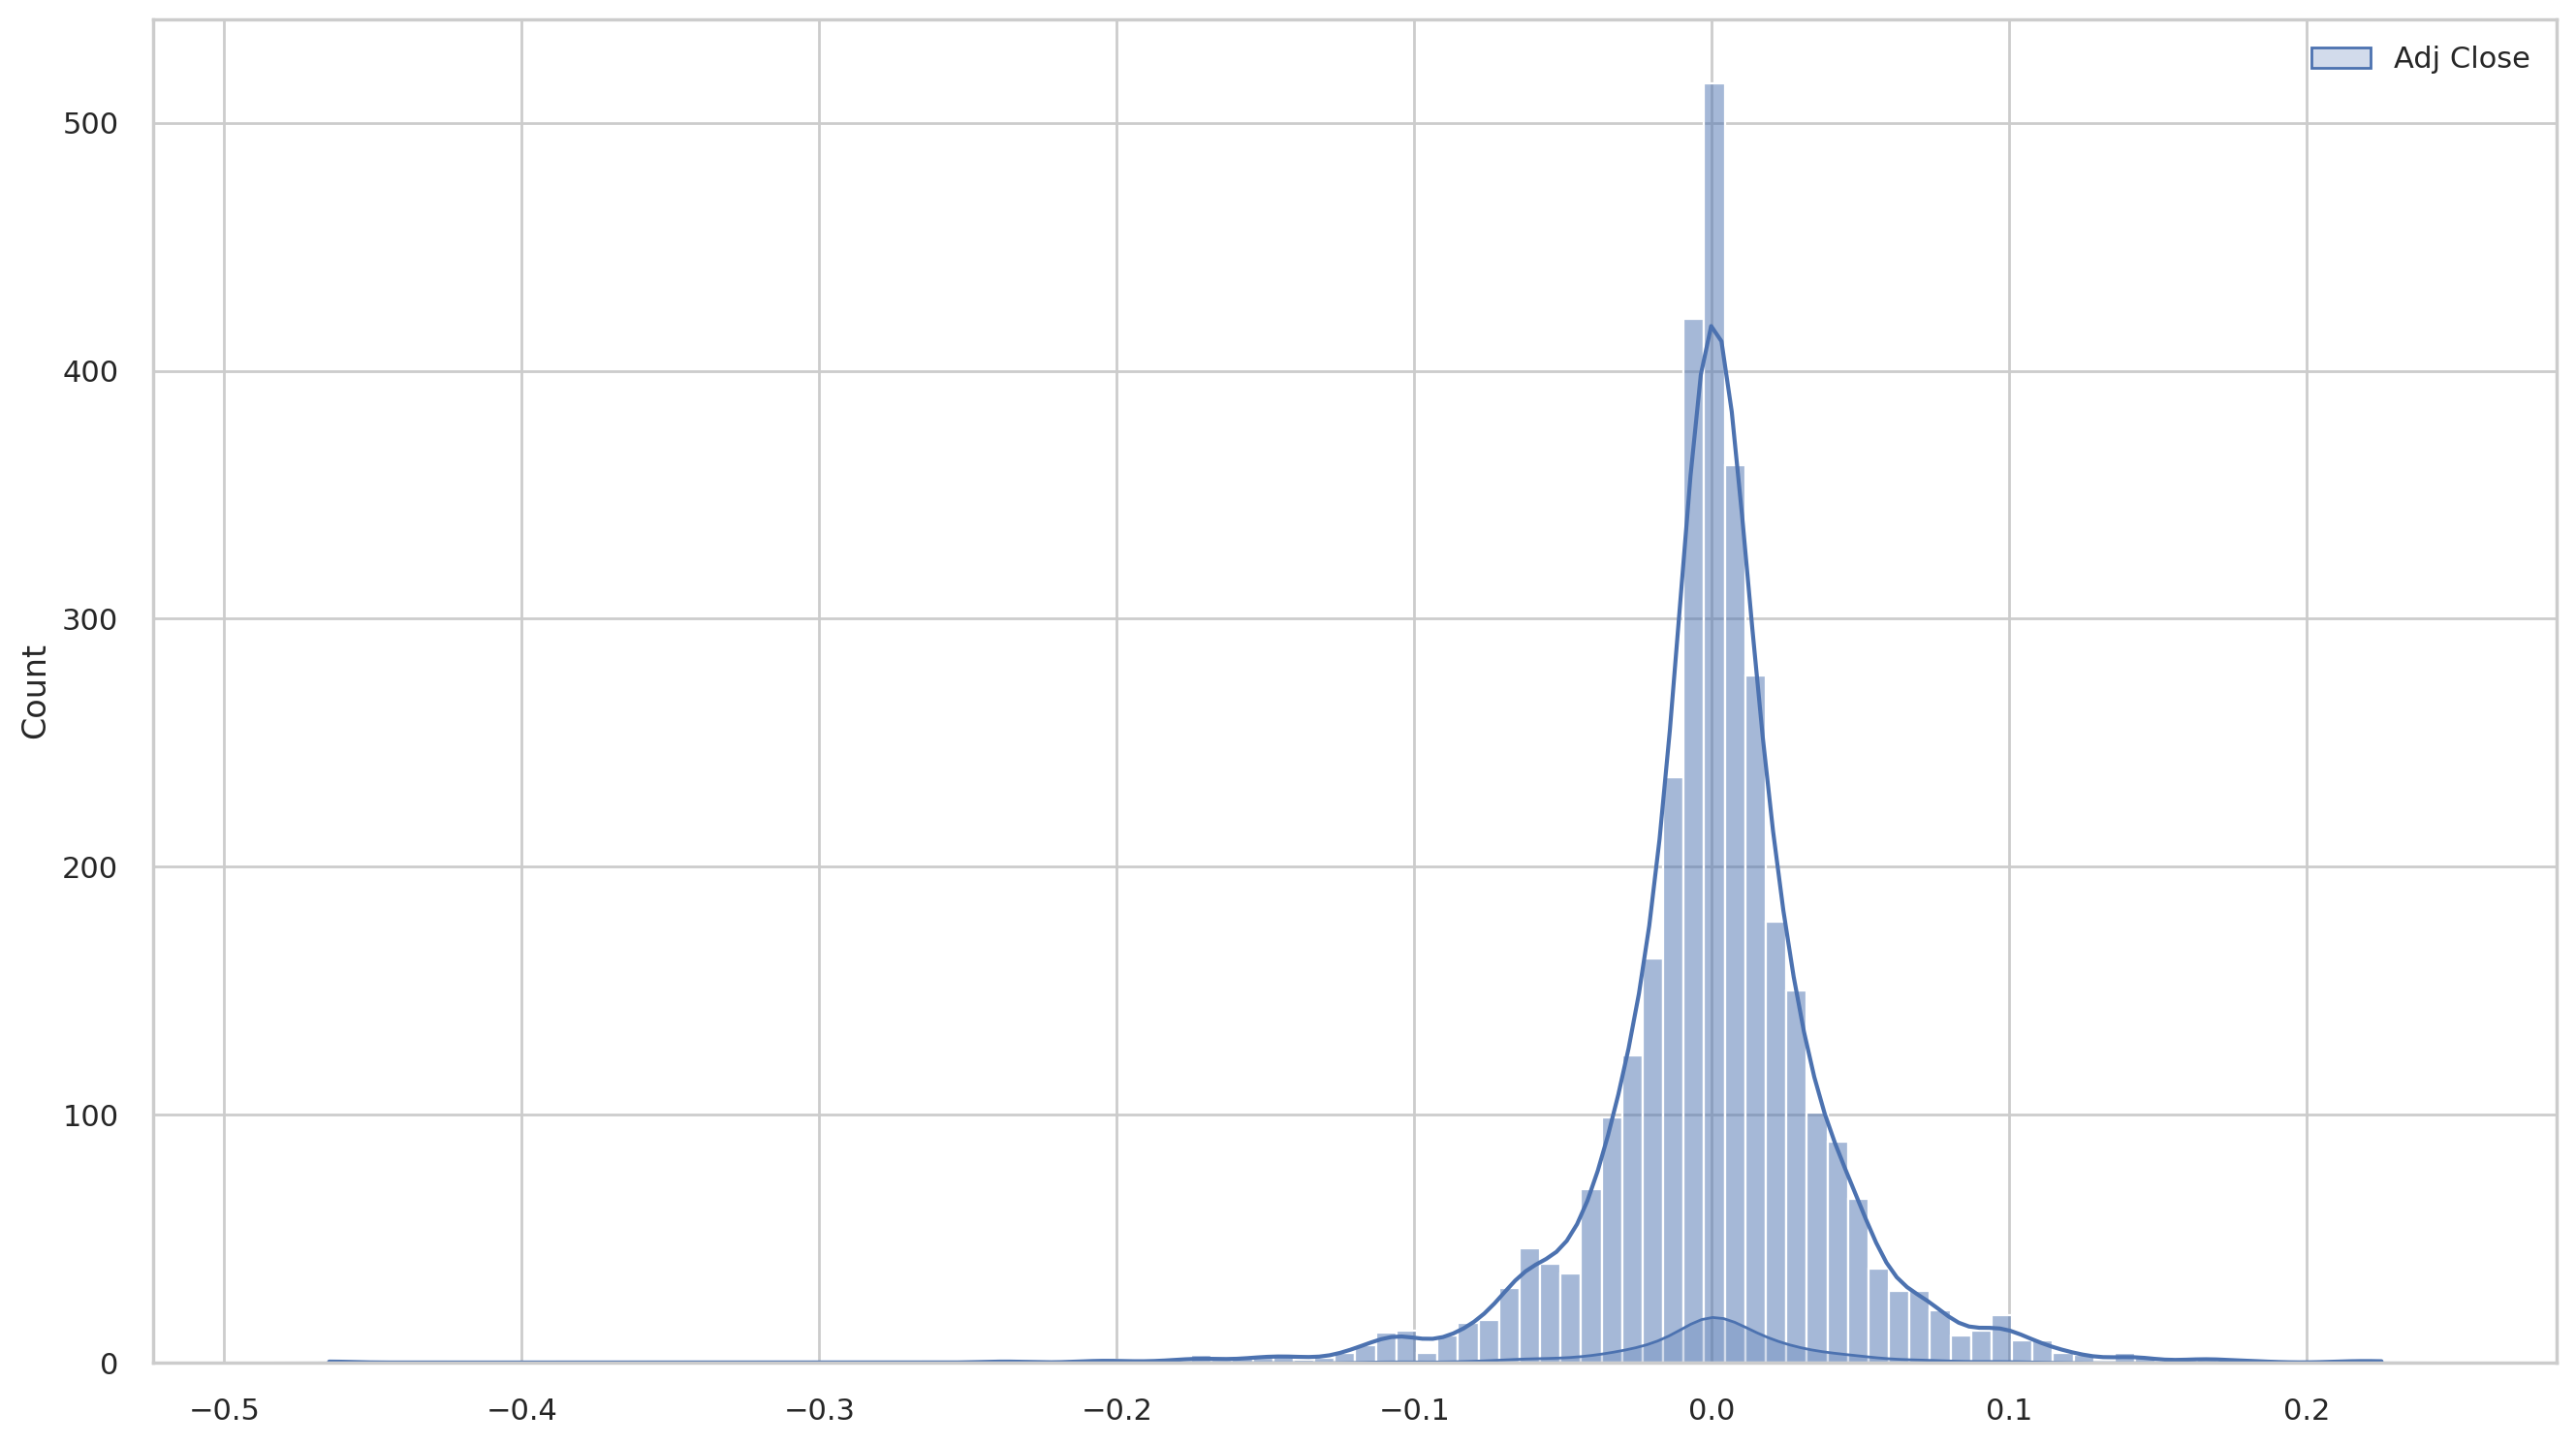

In [23]:
sns.set(style="whitegrid")  # Estilo del gráfico
sns.histplot(ret_bitcoin, bins=100, kde=True, color='skyblue')  # Histograma
sns.kdeplot(ret_bitcoin, shade=True, color="skyblue")

AttributeError: Rectangle.set() got an unexpected keyword argument 'kde'

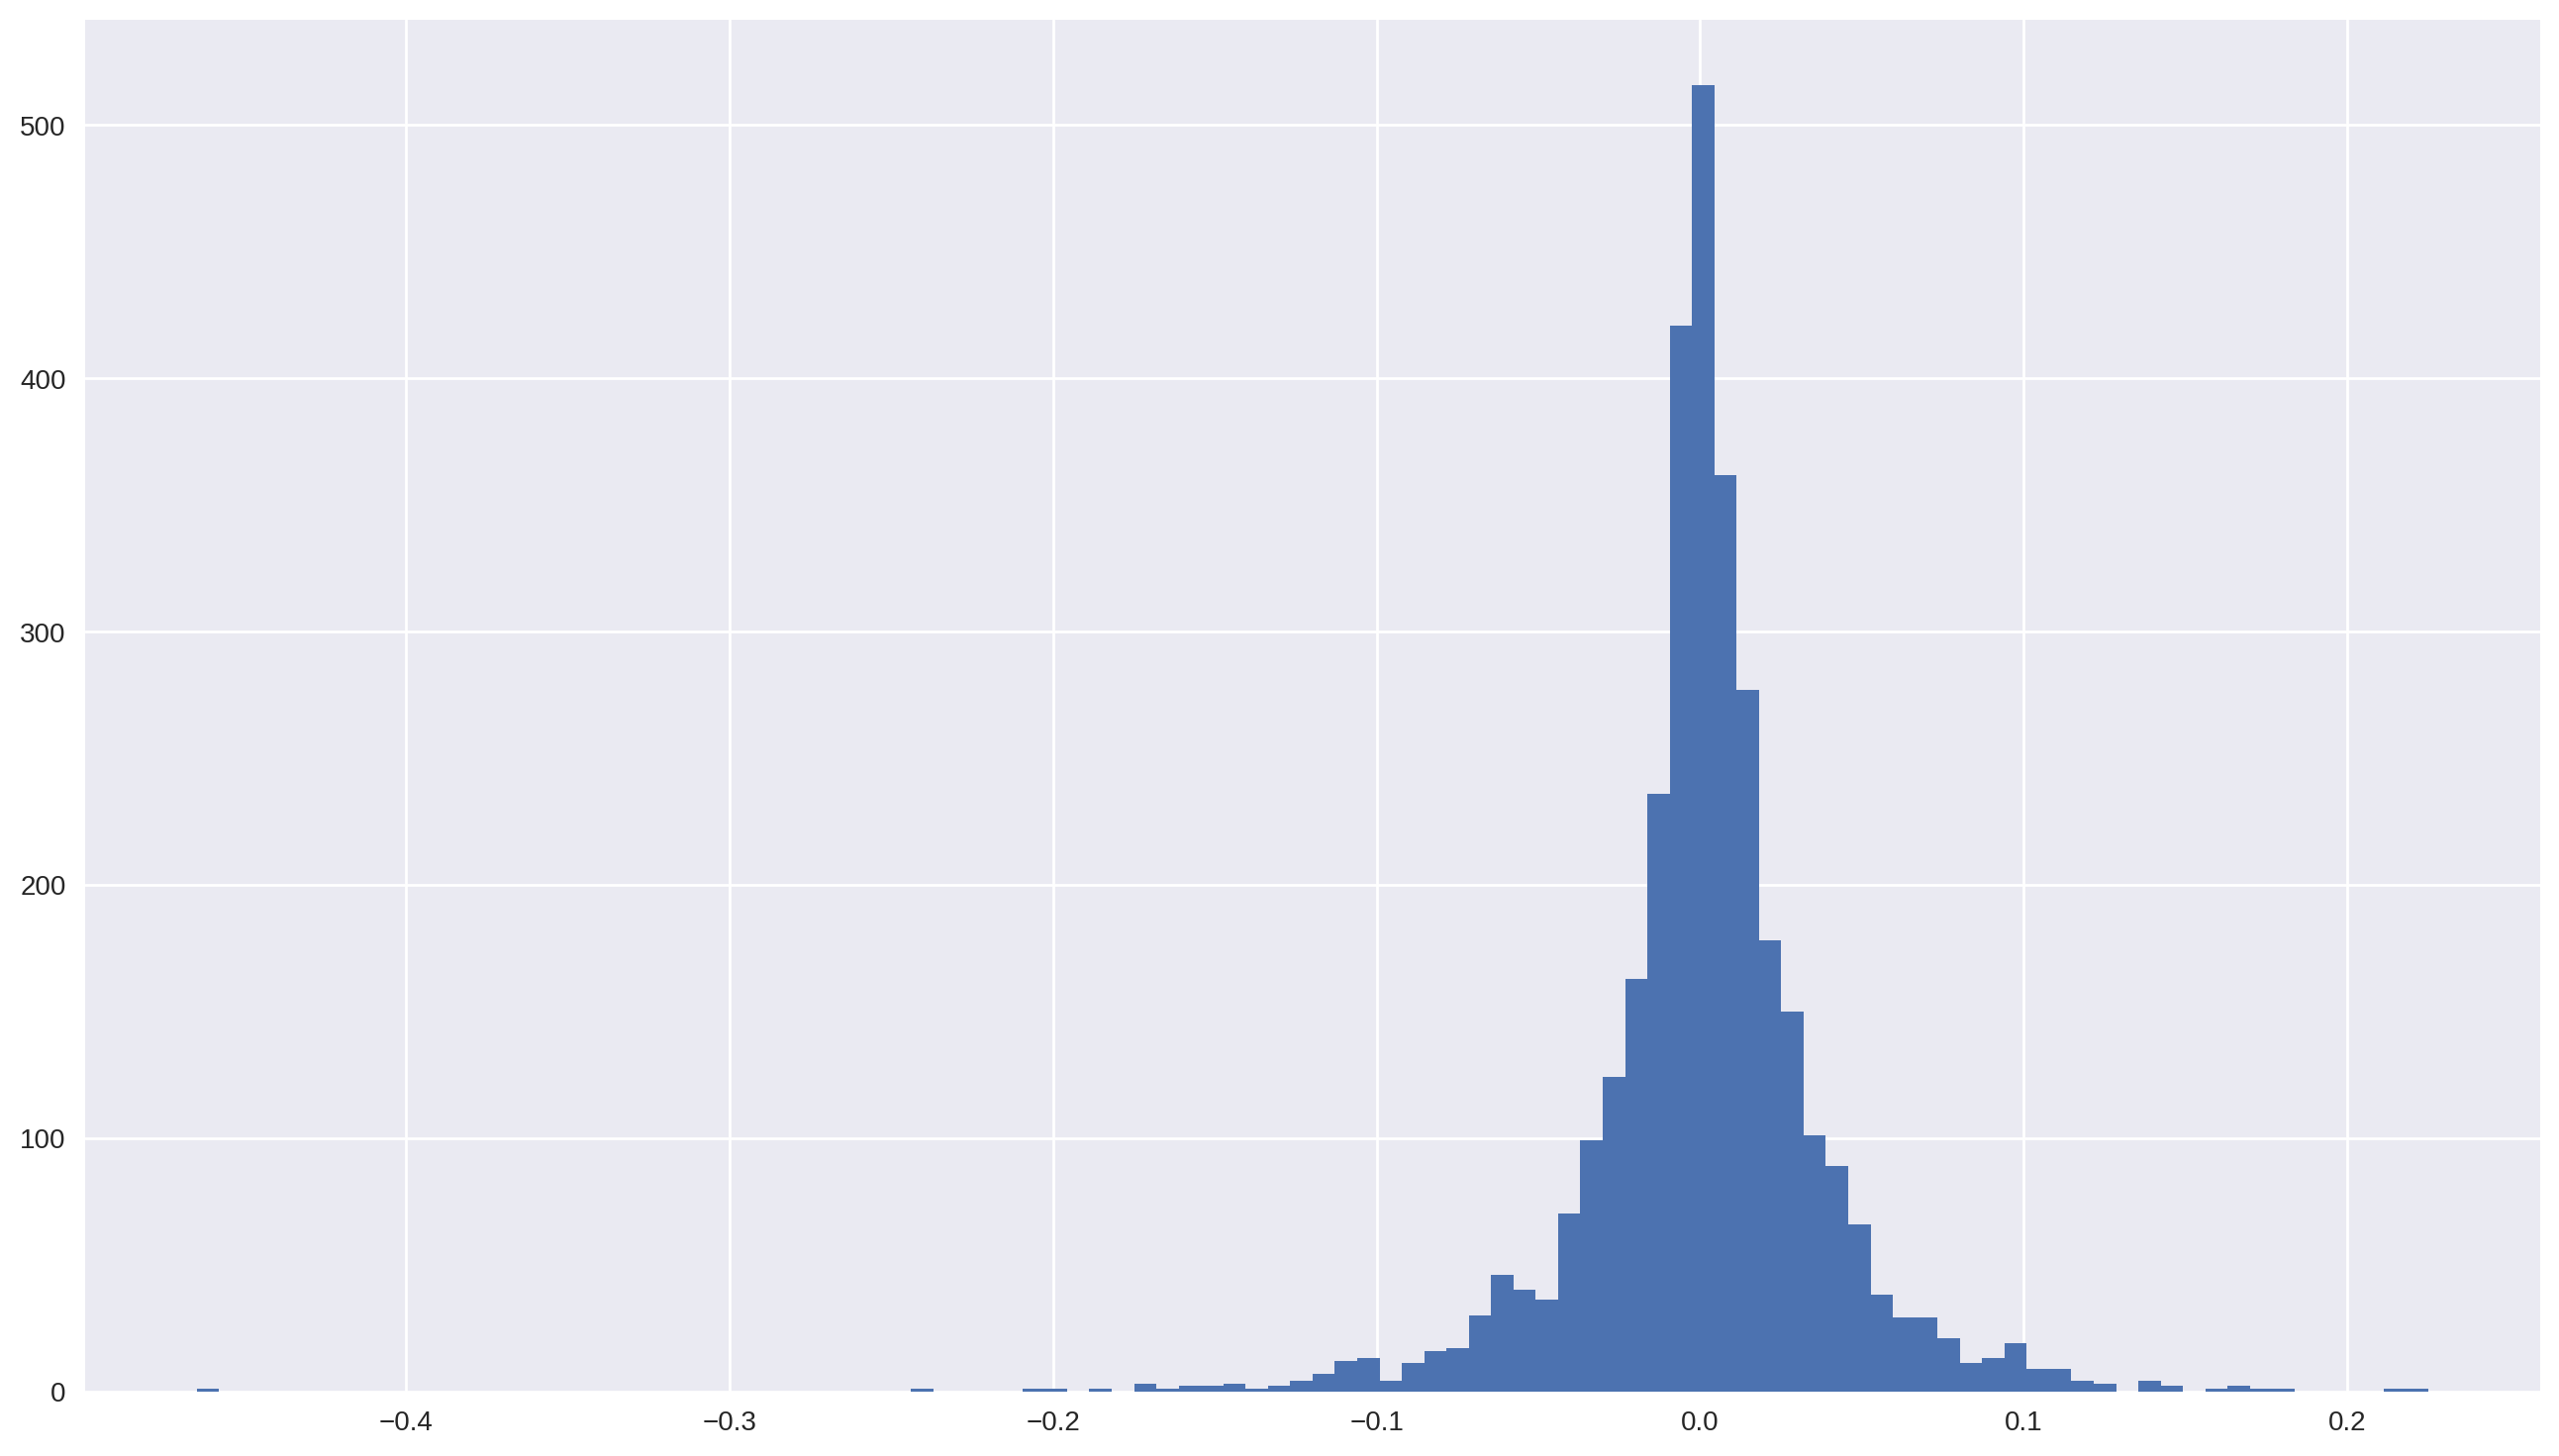

In [21]:
plt.hist(ret_bitcoin, bins=100, kde=True, alpha=0.5, label='Bitcoin')

In [20]:
# Obtener el ticker de Bitcoin
ticker = "BTC-USD"

# Descargar los datos de precios
bitcoin_data = yf.download(ticker)

ret_bitcoin = np.log(bitcoin_data[['Adj Close']]).diff().dropna()

# Crear un histograma interactivo
fig = px.histogram(ret_bitcoin, x='Adj Close', nbins=1000, title='Distribución de Retornos')

fig.show()


[*********************100%%**********************]  1 of 1 completed
